<a href="https://colab.research.google.com/github/jiiwon129/ESAA/blob/main/ESAA_YB_Project3_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **영화 관객수 예측 경진대회** (Regression)


https://dacon.io/competitions/open/235536/codeshare/4158?page=1&dtype=recent

## **1. 데이터 및 피처 확인**

필요한 모듈 임포트

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings(action='ignore')

In [9]:
# matplotlib 한글 깨짐 방지
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf
!apt-get update -qq
!apt-get install fonts-nanum -qq

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 34 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 0s (25.9 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 126102 files and direc

In [4]:
#한글 폰트 깨짐 방지
plt.style.use('fivethirtyeight')
plt.rc("font", family="NanumBarunGothic")
plt.rc("axes", unicode_minus =False)

제출파일 생성

In [5]:
submission=pd.read_csv('submission.csv')

데이터 불러오기

In [6]:
train=pd.read_csv("movies_train.csv")
test=pd.read_csv("movies_test.csv")

데이터 내 변수 확인
* title : 영화의 제목
* distributor : 배급사
* genre : 장르
* release_time : 개봉일
* time : 상영시간(분)
* screening_rat : 상영등급
* director : 감독이름
* dir_prev_bfnum : 해당 감독이 이 영화를 만들기 전 제작에 참여한 영화에서의 평균 관객수(단 관객수가 알려지지 않은 영화 제외)
* dir_prev_num : 해당 감독이 이 영화를 만들기 전 제작에 참여한 영화의 개수(단 관객수가 알려지지 않은 영화 제외)
* num_staff : 스텝수
* num_actor : 주연배우수
* box_off_num : 관객수

In [6]:
train.head()

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
0,개들의 전쟁,롯데엔터테인먼트,액션,2012-11-22,96,청소년 관람불가,조병옥,NaN,0,91,2,23398
1,내부자들,(주)쇼박스,느와르,2015-11-19,130,청소년 관람불가,우민호,1161602.50,2,387,3,7072501
2,은밀하게 위대하게,(주)쇼박스,액션,2013-06-05,123,15세 관람가,장철수,220775.25,4,343,4,6959083
3,나는 공무원이다,(주)NEW,코미디,2012-07-12,101,전체 관람가,구자홍,23894.00,2,20,6,217866
4,불량남녀,쇼박스(주)미디어플렉스,코미디,2010-11-04,108,15세 관람가,신근호,1.00,1,251,2,483387


In [7]:
# 데이터 프레임의 크기와 변수 확인
train.shape

(600, 12)

train의 경우, 600개의 행과 12개의 columns로 이루어져 있다.

submission의 경우, 243개의 행과 2개의 columns로 이루어져 있다.

-> 즉, 600개의 데이터를 학습시켜 243개의 데이터를 이용해 예측을 진행해야 한다.

## **2. EDA**

수치형 변수의 데이터 분포 왜곡 정도를 살펴보기 위해 히스토그램 시각화

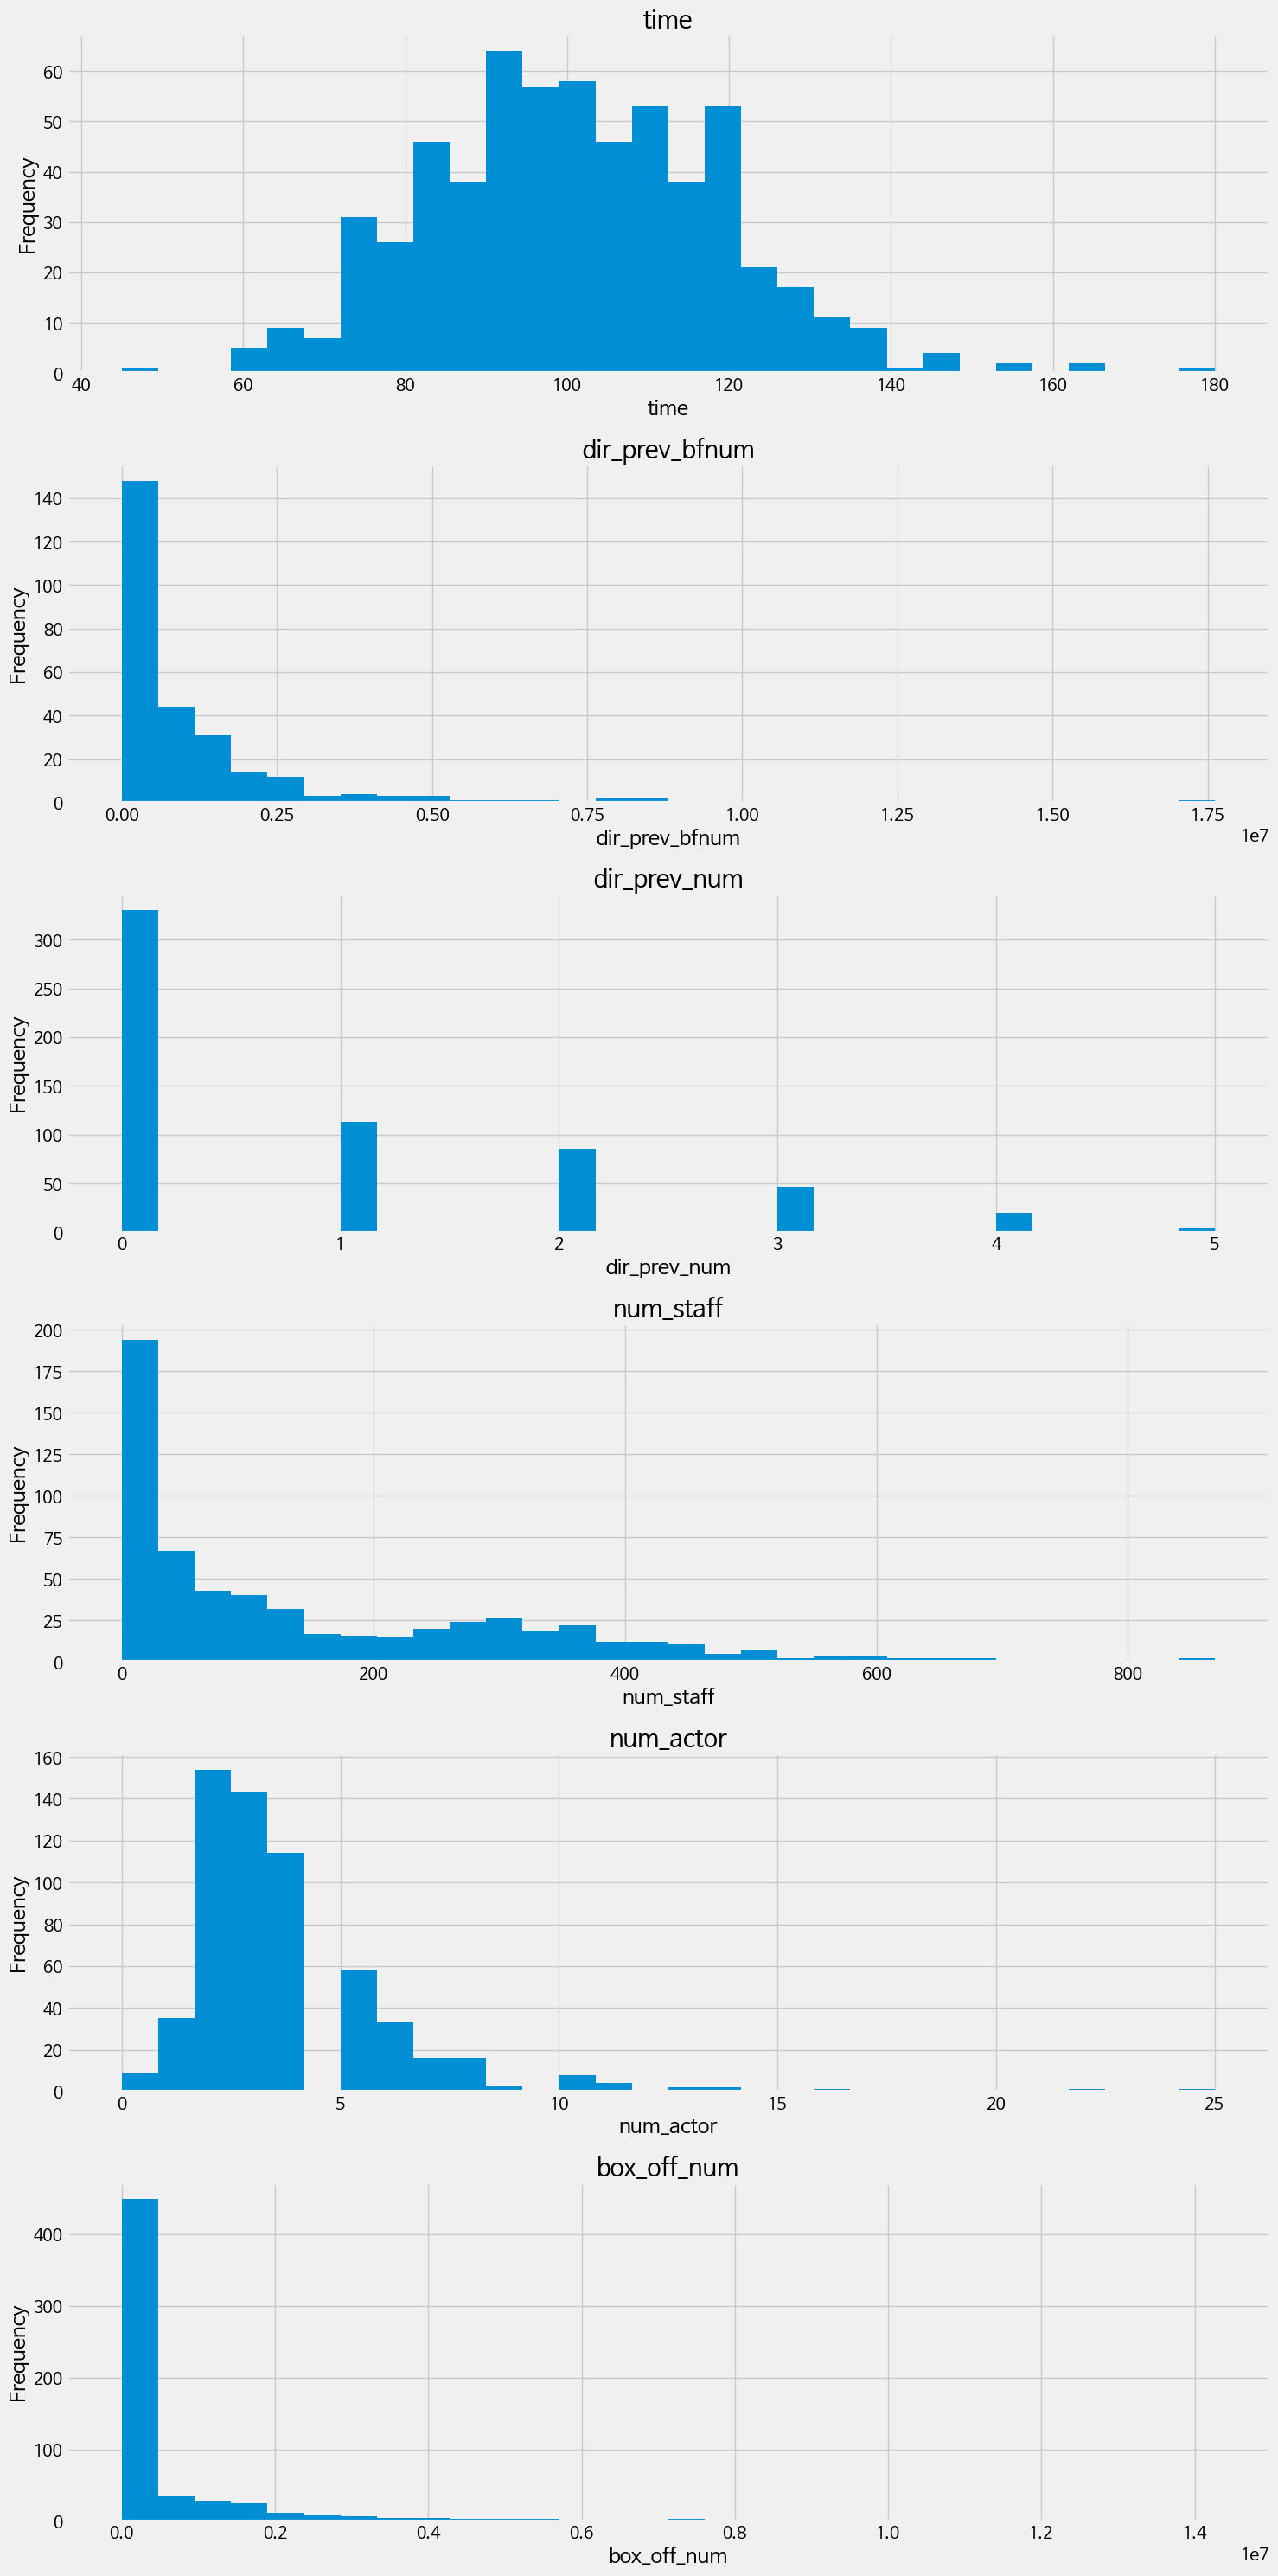

In [7]:
numeric_cols = train.select_dtypes(include='number').columns

# 히스토그램
plt.figure(figsize=(15, 5 * len(numeric_cols)))

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(len(numeric_cols), 1, i)
    train[col].hist(bins=30)
    plt.title(f'{col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

box_off_num과 나머지 변수의 상관관계 히트맵

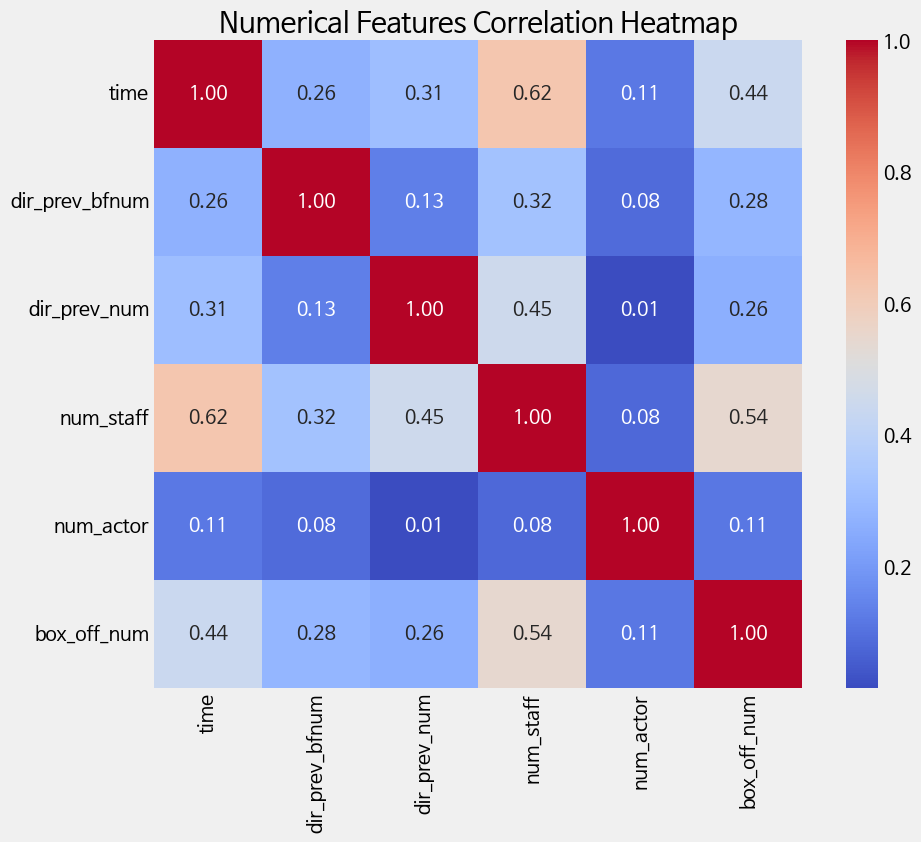

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

num_cols = train.select_dtypes(include=['int64', 'float64'])
matrix = num_cols.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title('Numerical Features Correlation Heatmap')
plt.show()

genre별 평균 관객수

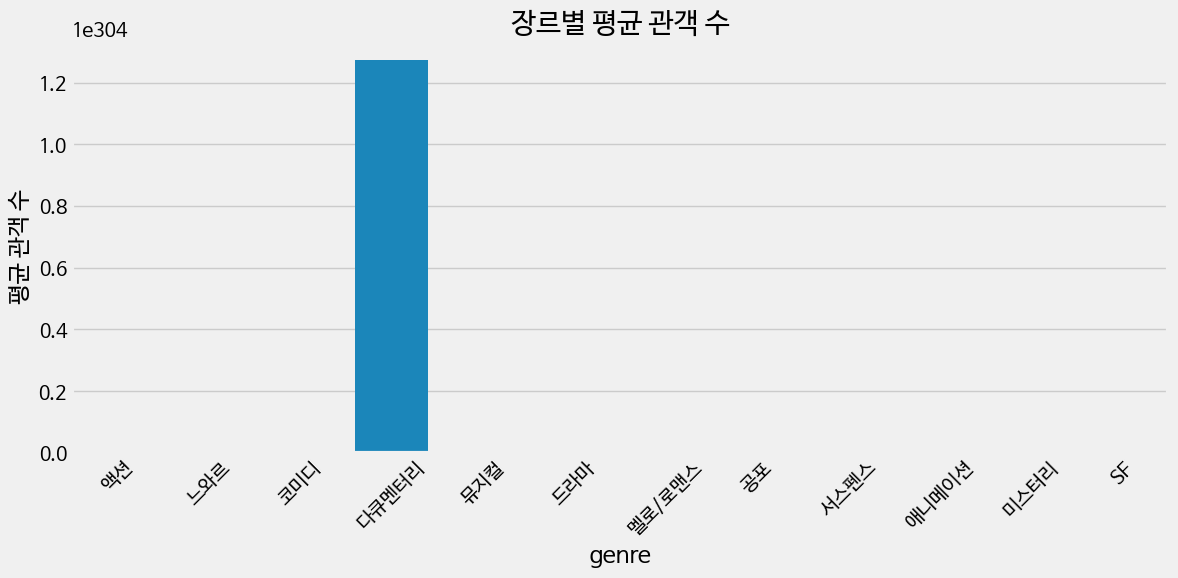

In [9]:
train_copy = train.copy()
train_copy['box_off_num'] = np.expm1(train_copy['box_off_num'])
train_copy['genre'] = train['genre'].astype(str)

plt.figure(figsize=(12,6))
sns.barplot(data=train_copy, x='genre', y='box_off_num', estimator=np.mean, ci=None)
plt.title("장르별 평균 관객 수")
plt.ylabel("평균 관객 수")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

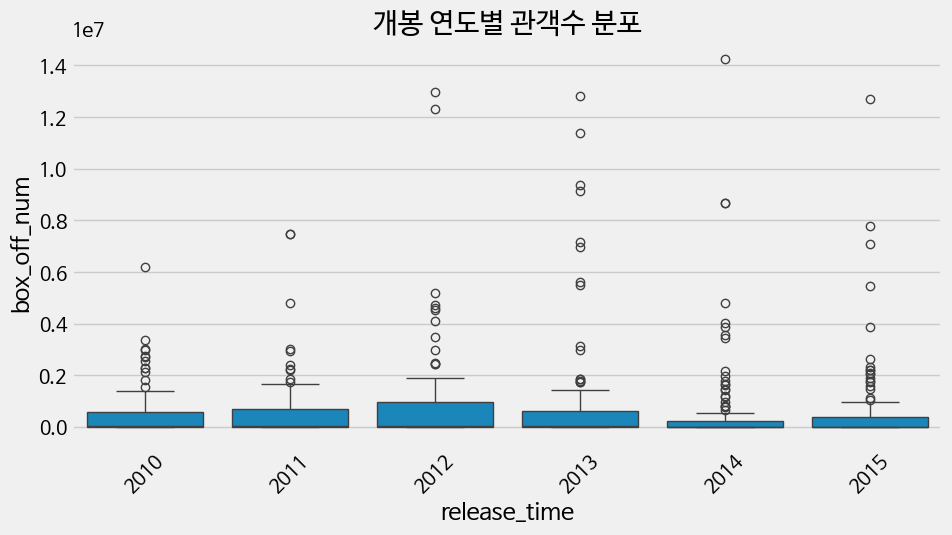

In [19]:
plt.figure(figsize=(10, 5))
sns.boxplot(x=pd.to_datetime(train['release_time']).dt.year, y='box_off_num', data=train)
plt.title("개봉 연도별 관객수 분포")
plt.xticks(rotation=45)
plt.show()

screening_rat (상영등급)별 분포

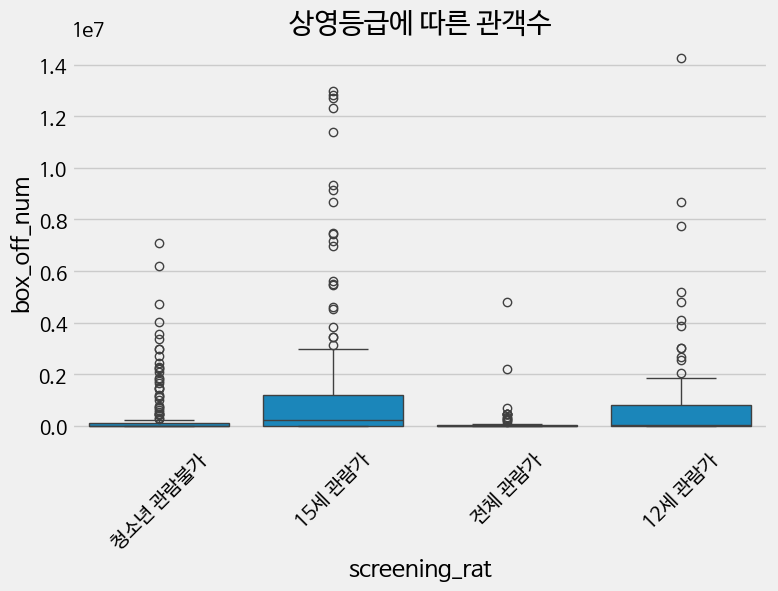

In [12]:
plt.figure(figsize=(8, 5))
sns.boxplot(x='screening_rat', y='box_off_num', data=train)
plt.title("상영등급에 따른 관객수")
plt.xticks(rotation=45)
plt.show()

## **3. 데이터 전처리**

In [22]:
#데이터 확인
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           600 non-null    object 
 1   distributor     600 non-null    object 
 2   genre           600 non-null    object 
 3   release_time    600 non-null    object 
 4   time            600 non-null    int64  
 5   screening_rat   600 non-null    object 
 6   director        600 non-null    object 
 7   dir_prev_bfnum  270 non-null    float64
 8   dir_prev_num    600 non-null    int64  
 9   num_staff       600 non-null    int64  
 10  num_actor       600 non-null    int64  
 11  box_off_num     600 non-null    int64  
dtypes: float64(1), int64(5), object(6)
memory usage: 56.4+ KB


#### 1) 결측치 처리

위에서 이미 info( )를 이용하여 결측치를 확인하였지만, isna()를 이용하여 결측치에 대한 개수를 추가적으로 확인하도록 하자.

In [23]:
#결측치 존재 여부 확인
train.isna().sum()

,0
title,0
distributor,0
genre,0
release_time,0
time,0
screening_rat,0
director,0
dir_prev_bfnum,330
dir_prev_num,0
num_staff,0


결측치의 형태를 확인해보니, 이들의 형태는 NaN의 결측값 형태로 나타남을 알 수 있다.

-> dir_prev_bfnum의 null값이 데이터 수의 절반 이상으로 나타나고, 유사한 의미를 가지는 dir_prev_num 변수가 존재하므로 이 변수는 제거한다.

- dir_prev_bfnum : 결측치 존재. 감독의 전작이 없는 경우이기 때문에 결측값을 0으로 변경하는 작업 수행 가능하지만 이번 경우에는 제거한다.

In [24]:
# 결측치가 많은 데이터 제거
train=train.drop(['dir_prev_bfnum'],axis=1)
test=test.drop(['dir_prev_bfnum'],axis=1)

#### 2) 필요없는 변수 제거

- title: 모델 적용에 큰 의미가 없기 때문에 제거
  - 하지만 이 경우 제출파일 submission.csv와 test.csv의 'title' 변수의 순서가 같아야만 제거가 가능함

In [25]:
print((test['title'].values == submission['title'].values).all())

True


순서가 같으므로 제거한다.

In [26]:
train=train.drop(['title'],axis=1)
test=test.drop(['title'],axis=1)

#### 3) 이름이 다른 동일 변수 처리

- distributor : NEW와 시네마달 배급사가 (주)NEW, 시네마 달 이라는 다른 이름으로 들어간 것이 확인됨. 후자 데이터의 배급사 정보를 전자 정보로 변경해주는 작업 수행

1. distributor -> 시네마달, 시네마 달은 같은 배급사

In [27]:
print(train[train['distributor']=='시네마 달'])

    distributor  genre release_time  time screening_rat director  \
107       시네마 달  다큐멘터리   2012-07-26   118       15세 관람가      김경만   
108       시네마 달  다큐멘터리   2012-04-26    98       15세 관람가       경순   
167       시네마 달  다큐멘터리   2013-03-28    75        전체 관람가     지율스님   
212       시네마 달  다큐멘터리   2010-09-09    95        전체 관람가      권우정   
216       시네마 달  다큐멘터리   2013-01-24    89       12세 관람가      박배일   
497       시네마 달  다큐멘터리   2011-01-13    93       15세 관람가      정호현   

     dir_prev_num  num_staff  num_actor  box_off_num  
107             0          6          0          652  
108             2          4         10         2119  
167             0         11          0        10942  
212             0          7          3         2418  
216             0          6          2         1240  
497             0          0          2         4340  


In [28]:
print(train[train['distributor']=='시네마달'])

    distributor  genre release_time  time screening_rat director  \
204        시네마달  다큐멘터리   2014-10-23    77       15세 관람가      이상호   
274        시네마달  다큐멘터리   2014-03-06    92       12세 관람가      홍리경   
342        시네마달  다큐멘터리   2013-08-15    92        전체 관람가       권효   
363        시네마달  다큐멘터리   2011-09-01    87       12세 관람가      김성균   
407        시네마달  다큐멘터리   2014-10-23    77       15세 관람가      이상호   
425        시네마달  다큐멘터리   2011-11-24   136        전체 관람가      이강현   
447        시네마달  다큐멘터리   2014-05-15    94       12세 관람가      태준식   
534        시네마달  다큐멘터리   2015-07-16   102       15세 관람가      박배일   
545        시네마달    드라마   2012-11-15    45      청소년 관람불가     이송희일   
577        시네마달  다큐멘터리   2015-02-05   108       12세 관람가      김형주   

     dir_prev_num  num_staff  num_actor  box_off_num  
204             0         35          1        50308  
274             0          7          3         5808  
342             1         24          4         5014  
363             0          6   

In [29]:
list_cinemadal_train = train[train['distributor']=='시네마 달'].index
list_cinemadal_test = test[test['distributor']=='시네마 달'].index

2. distributor -> NEW, (주)NEW는 같은 배급사

In [30]:
print(train[train['distributor']=='NEW'])

    distributor   genre release_time  time screening_rat director  \
39          NEW  멜로/로맨스   2012-02-29   121       15세 관람가      전계수   
90          NEW     드라마   2014-05-14   132      청소년 관람불가      김대우   
97          NEW   애니메이션   2013-11-21   100      청소년 관람불가      연상호   
183         NEW      공포   2010-07-28    84       15세 관람가      유선동   
358         NEW      액션   2011-09-29   119      청소년 관람불가      허종호   
389         NEW     드라마   2013-11-07   108      청소년 관람불가      전규환   
397         NEW     코미디   2010-12-22   111       12세 관람가      김영탁   
468         NEW     코미디   2012-06-21   115       15세 관람가      박철관   

     dir_prev_num  num_staff  num_actor  box_off_num  
39              2        315          2      1726227  
90              4        379          4      1441990  
97              0        136          4        22525  
183             2        307          5       857038  
358             2        109          2       471547  
389             0         13          2         

In [31]:
print(train[train['distributor']=='(주)NEW'])

    distributor   genre release_time  time screening_rat director  \
3        (주)NEW     코미디   2012-07-12   101        전체 관람가      구자홍   
28       (주)NEW     느와르   2010-03-18    93      청소년 관람불가      김철한   
48       (주)NEW      액션   2014-11-26   112       15세 관람가       최호   
67       (주)NEW     드라마   2015-11-25   106       15세 관람가      정기훈   
86       (주)NEW     드라마   2012-12-19   120       15세 관람가      정기훈   
104      (주)NEW     드라마   2011-06-23   121      청소년 관람불가      전재홍   
122      (주)NEW     드라마   2013-12-18   127       15세 관람가      양우석   
131      (주)NEW     드라마   2012-09-06   104      청소년 관람불가      김기덕   
164      (주)NEW     드라마   2015-09-24   121      청소년 관람불가      홍상수   
190      (주)NEW     드라마   2012-01-18   100       15세 관람가      정지영   
214      (주)NEW      SF   2010-11-10   114       15세 관람가      김민석   
244      (주)NEW     드라마   2011-02-17   118       15세 관람가      추창민   
287      (주)NEW     드라마   2014-01-22   120       15세 관람가      한동욱   
328      (주)NEW     드라마   2013-10-

In [32]:
list_new_train = train[train['distributor']=='(주)NEW'].index
list_new_test = test[test['distributor']=='(주)NEW'].index

1. '시네마 달' -> '시네마달'로 변경
2. '(주)NEW' -> 'NEW'로 변경

In [33]:
test.head()

,distributor,genre,release_time,time,screening_rat,director,dir_prev_num,num_staff,num_actor
0,시네마서비스,느와르,2010-01-07,125,청소년 관람불가,김형준,2,304,3
1,(주)쇼박스,멜로/로맨스,2010-01-14,113,12세 관람가,이광재,4,275,3
2,CJ 엔터테인먼트,드라마,2010-01-28,115,12세 관람가,강대규,3,419,7
3,(주)쇼박스,액션,2010-02-04,116,15세 관람가,장훈,2,408,2
4,CJ 엔터테인먼트,공포,2010-02-18,110,15세 관람가,권호영,1,380,1


In [34]:
train.loc[list_cinemadal_train, 'distributor'] = '시네마달'
train.loc[list_new_train, 'distributor'] = 'NEW'

In [35]:
test.loc[list_cinemadal_test, 'distributor'] = '시네마달'
test.loc[list_new_test, 'distributor'] = 'NEW'

In [36]:
print(train[train['distributor']=='시네마 달'])
print(train[train['distributor']=='(주)NEW'])

Empty DataFrame
Columns: [distributor, genre, release_time, time, screening_rat, director, dir_prev_num, num_staff, num_actor, box_off_num]
Index: []
Empty DataFrame
Columns: [distributor, genre, release_time, time, screening_rat, director, dir_prev_num, num_staff, num_actor, box_off_num]
Index: []


In [37]:
print(test[test['distributor']=='시네마 달'])
print(test[test['distributor']=='(주)NEW'])

Empty DataFrame
Columns: [distributor, genre, release_time, time, screening_rat, director, dir_prev_num, num_staff, num_actor]
Index: []
Empty DataFrame
Columns: [distributor, genre, release_time, time, screening_rat, director, dir_prev_num, num_staff, num_actor]
Index: []


#### 4) 빈도 계산 후 피처 추가

변수 내 level이 너무 많은 distributor(배급사), director(감독)의 level별로 빈도 수를 계산한 뒤, 이 값을 num_distributor, num_director로 추가


- distributor

In [38]:
print(train['distributor'].value_counts().shape)
train['distributor'].value_counts().head()

(167,)


,count
distributor,
CJ 엔터테인먼트,54
롯데엔터테인먼트,52
NEW,38
(주)마운틴픽쳐스,29
인디스토리,26


배급사의 종류가 167개로 너무 많음을 확인
-> count 수를 피처로 추가

In [39]:
train['num_distributor'] = train['distributor'].map(train['distributor'].value_counts())
train=train.drop('distributor',axis=1)
test['num_distributor'] = test['distributor'].map(test['distributor'].value_counts())
test=test.drop('distributor',axis=1)

- director

In [40]:
print(train['director'].value_counts().shape)
train['director'].value_counts().head()

(472,)


,count
director,
홍상수,7
우민호,4
전규환,4
신재호,4
장률,4


위의 distributor와 동일하게 전처리 진행

In [41]:
train['num_director'] = train['director'].map(train['director'].value_counts())
train=train.drop('director',axis=1)
test['num_director'] = test['director'].map(test['director'].value_counts())
test=test.drop('director',axis=1)

#### 5) datetime 객체 변환

- release_time : datetime이 아닌 문자열 정보로 나오기 때문에 datetime 객체로 변경해주는 작업 수행

In [42]:
#날짜가 stringtype으로 입력되어 있어서 datetype으로 변경하기
import pandas as pd
import datetime as dt

In [43]:
train['release_time'] = pd.to_datetime(train['release_time'])
test['release_time'] = pd.to_datetime(test['release_time'])

In [44]:
sort_Data=train.sort_values(by=['release_time'], ascending=True)
print(sort_Data['release_time'].head())
print(sort_Data['release_time'].nunique())

109   2010-01-02
207   2010-01-14
475   2010-01-14
46    2010-01-14
228   2010-01-14
Name: release_time, dtype: datetime64[ns]
330


#### 6) datetime 객체로 년도, 월 파생변수 생성

In [45]:
# train 데이터에서 연도와 월 추출
train['year'] = train['release_time'].dt.year
train['month'] = train['release_time'].dt.month
train = train.drop(['release_time'], axis=1)

# test 데이터에 동일하게 적용
test['year'] = test['release_time'].dt.year
test['month'] = test['release_time'].dt.month
test = test.drop(['release_time'], axis=1)

#### 7) 특정 변수 로그 변환

왜곡이 심해보이는 dir_prev_num, num_staff, num_actor, box_off_num 로그 변환 진행
- 이후 예측 시에 target 변수인 box_off_num은 다시 역변환

In [47]:
log_cols = ['dir_prev_num', 'num_staff', 'num_actor']

# 로그 변환: log(x + 1) 사용해 0 값도 안전하게 처리
for col in log_cols:
    train[f'{col}'] = np.log1p(train[col])
    test[f'{col}'] = np.log1p(test[col])

# test 데이터엔 target 변수가 존재하지 않으므로 따로 변환
train['box_off_num'] = np.log1p(train['box_off_num'])

#### 8) 피처 인코딩

In [48]:
train.head()

,genre,time,screening_rat,dir_prev_num,num_staff,num_actor,box_off_num,num_distributor,num_director,year,month
0,액션,96,청소년 관람불가,0.000000,4.521789,1.098612,10.060449,52,1,2012,11
1,느와르,130,청소년 관람불가,1.098612,5.961005,1.386294,15.771725,26,4,2015,11
2,액션,123,15세 관람가,1.609438,5.840642,1.609438,15.755558,26,1,2013,6
3,코미디,101,전체 관람가,1.098612,3.044522,1.945910,12.291640,38,1,2012,7
4,코미디,108,15세 관람가,0.693147,5.529429,1.098612,13.088575,2,1,2010,11


Categorical 변수로 distributor, genre, screening_rat가 있으므로 원-핫 인코딩 진행

In [49]:
# 원-핫 인코딩
train=pd.get_dummies(train, columns=['genre','screening_rat','year','month'],
                     prefix=['genre','screening_rat','year','month'])
test=pd.get_dummies(test, columns=['genre','screening_rat','year','month'],
                     prefix=['genre','screening_rat','year','month'])

In [50]:
train.head()

,time,dir_prev_num,num_staff,num_actor,box_off_num,num_distributor,num_director,genre_SF,genre_공포,genre_느와르,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,96,0.000000,4.521789,1.098612,10.060449,52,1,False,False,False,...,False,False,False,False,False,False,False,False,True,False
1,130,1.098612,5.961005,1.386294,15.771725,26,4,False,False,True,...,False,False,False,False,False,False,False,False,True,False
2,123,1.609438,5.840642,1.609438,15.755558,26,1,False,False,False,...,False,False,False,True,False,False,False,False,False,False
3,101,1.098612,3.044522,1.945910,12.291640,38,1,False,False,False,...,False,False,False,False,True,False,False,False,False,False
4,108,0.693147,5.529429,1.098612,13.088575,2,1,False,False,False,...,False,False,False,False,False,False,False,False,True,False


## **4. Feature Scaling**

target깂을 제외한 numeric 변수를 StandardScaler 클래스를 이용해 표준화

In [36]:
# 표준화
from sklearn.preprocessing import StandardScaler

standard_scaler = StandardScaler()

continuous_cols = ['time','dir_prev_num','num_staff','num_actor','num_distributor','num_director']

train[continuous_cols] = standard_scaler.fit_transform(train[continuous_cols])
test[continuous_cols] = standard_scaler.transform(test[continuous_cols])

## **5. Modeling**

학습 데이터 X, Y 데이터 세트 분리
- target 변수: 'box_off_num'

In [37]:
X=train.drop(['box_off_num'],axis=1)
y=train['box_off_num']

In [ ]:
from sklearn.model_selection import GridSearchCV, train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=156)

1. X와 y 자체를 train 데이터 세트로 사용
2. X와 y를 다시 train와 test용 데이터 세트로 분해하여 모델링 예측 진행

- 모델링 방법에 따라 자유롭게 선택하여 진행

평가 지표 RMSE 함수 정의

In [38]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings(action='ignore')

In [39]:
kfolds = KFold(n_splits=5, shuffle=True, random_state=156)

def cv_rmse(model, X, y, kfolds):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=kfolds))
    return (rmse)

### 1) Linear Regression

In [93]:
from sklearn.linear_model import LinearRegression

In [94]:
lr=LinearRegression()
lr.fit(X,y)
y_pred_log=lr.predict(test)
y_pred=np.expm1(y_pred_log)

In [96]:
score = cv_rmse(lr, X, y, kfolds)
print("Linear Regression: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Linear Regression: 2.1233 (0.0849)


### 2) Ridge

In [40]:
from sklearn.linear_model import RidgeCV

In [74]:
alphas_ridge = [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 20, 50, 100, 200, 500, 1000]

ridge=RidgeCV(alphas=alphas_ridge, cv=kfolds)
ridge.fit(X, y)

y_pred_log = ridge.predict(test)
y_pred=np.expm1(y_pred_log)

In [75]:
score = cv_rmse(ridge, X, y, kfolds)
print("Ridge: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Ridge: 2.1066 (0.0808)


### 3) Lasso

In [44]:
from sklearn.linear_model import LassoCV

In [77]:
alphas_lasso = [0.0001, 0.001, 0.005, 0.01, 0.05, 0.1]

lasso = LassoCV(alphas=alphas_lasso, cv=kfolds, random_state=156)
lasso.fit(X, y)

y_pred_log = lasso.predict(test)
y_pred=np.expm1(y_pred_log)

In [78]:
score = cv_rmse(lasso, X, y, kfolds)
print("Lasso: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Lasso: 2.1160 (0.0679)


### 4) ElasticNet

In [80]:
from sklearn.linear_model import ElasticNetCV

In [109]:
alphas_elasticnet = [0.0001, 0.001, 0.01, 0.1, 1.0]
l1_ratios = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]  # 1.0은 Lasso, 0.0은 Ridge

elasticnet = ElasticNetCV(alphas=alphas_elasticnet,
                          l1_ratio=l1_ratios,
                          cv=kfolds,
                          max_iter=10000,
                          random_state=156)
elasticnet.fit(X, y)

y_pred_log = elasticnet.predict(test)
y_pred=np.expm1(y_pred_log)

In [82]:
score = cv_rmse(elasticnet, X, y, kfolds)
print("elasticnet: {:.4f} ({:.4f})".format(score.mean(), score.std()))

elasticnet: 2.1097 (0.0795)


### 5) XGBoost

In [52]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

In [53]:
xgb = XGBRegressor(random_state=156)

param_grid_xgb = {
     'n_estimators': [100, 300, 500],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.005, 0.01, 0.05, 0.1],
    'num_leaves': [20, 30, 40, 50, 60],
    'subsample': [0.5, 0.7, 0.9, 1.0],
    'colsample_bytree': [0.5, 0.7, 1.0]
}

grid_search_xgb = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid_xgb,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=1,
    n_jobs=-1
)

grid_search_xgb.fit(X, y)

xgb_best_params = grid_search_xgb.best_params_

print("XGBoost 최적 하이퍼파라미터:", xgb_best_params)

Fitting 5 folds for each of 2160 candidates, totalling 10800 fits
XGBoost 최적 하이퍼파라미터: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 500, 'num_leaves': 20, 'subsample': 0.5}


In [84]:
xgb = XGBRegressor(**xgb_best_params, random_state=156)
xgb.fit(X, y)

y_pred_log = xgb.predict(test)
y_pred=np.expm1(y_pred_log)

In [85]:
score = cv_rmse(xgb, X, y, kfolds)
print("XGBoost: {:.4f} ({:.4f})".format(score.mean(), score.std()))

XGBoost: 1.8188 (0.0725)


### 6) LightGBM

In [57]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV

In [58]:
param_grid_lgbm = {
    'n_estimators': [100, 300, 500],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.005, 0.01, 0.05, 0.1],
    'num_leaves': [20, 30, 40, 50, 60],
    'subsample': [0.5, 0.7, 0.9, 1.0],
    'colsample_bytree': [0.5, 0.7, 1.0]
}

grid_search_lgbm = GridSearchCV(
    estimator=LGBMRegressor(random_state=156),
    param_grid=param_grid_lgbm,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=1,
    n_jobs=-1
)

grid_search_lgbm.fit(X, y)

lgbm_best_params = grid_search_lgbm.best_params_

print("LightGBM 최적 하이퍼파라미터:", lgbm_best_params)

Fitting 5 folds for each of 2160 candidates, totalling 10800 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000163 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 332
[LightGBM] [Info] Number of data points in the train set: 600, number of used features: 36
[LightGBM] [Info] Start training from score 9.951971
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

In [87]:
lgbm = LGBMRegressor(**lgbm_best_params, random_state=156)
lgbm.fit(X, y)

y_pred_log = lgbm.predict(test)
y_pred=np.expm1(y_pred_log)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000108 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 332
[LightGBM] [Info] Number of data points in the train set: 600, number of used features: 36
[LightGBM] [Info] Start training from score 9.951971
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

In [88]:
score = cv_rmse(lgbm, X, y, kfolds)
print("LightGBM: {:.4f} ({:.4f})".format(score.mean(), score.std()))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000115 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 299
[LightGBM] [Info] Number of data points in the train set: 480, number of used features: 35
[LightGBM] [Info] Start training from score 9.941734
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

### 7) Random Forest

In [67]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [69]:
param_grid_rf = {
    'n_estimators': [100, 300, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

grid_search_rf = GridSearchCV(
    estimator=RandomForestRegressor(random_state=156),
    param_grid=param_grid_rf,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=1,
    n_jobs=-1
)

grid_search_rf.fit(X, y)

rf_best_params = grid_search_rf.best_params_

print("Random Forest 최적 하이퍼파라미터:", rf_best_params)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Random Forest 최적 하이퍼파라미터: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}


In [90]:
rf = RandomForestRegressor(**rf_best_params, random_state=156)
rf.fit(X, y)

y_pred_log = rf.predict(test)
y_pred=np.expm1(y_pred_log)

In [91]:
score = cv_rmse(rf, X, y, kfolds)
print("Random Forest: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Random Forest: 1.8249 (0.0937)


### 8) Stacking

#### 8-1) 기본 모델 및 다양한 조합의 스태킹 앙상블


#####  모델링 방향성 정리
- 기본 모델

스태킹 모델을 맡았기 때문에 중심이 될 수 있는 기본적인 모델들을 먼저 확인했다.
LinearRegression 모델, Ridge 모델, Lasso 모델, ElasticNet 모델을 확인했고,
Ridge와 Lasso, RF를 결합한 Stacking 모델을 확인했다.

그 결과 ridge 모델과 스태킹 모델의 성능이 좋은 것으로 나타났다.
이후 기본 모델들을 모두 변형, 발전시켜 성능을 비교했다.








모델링 진행 과정에서 X, y 데이터를 다시 train, test 데이터 세트로 분리하여 예측을 진행하였고, 리더보드 점수를 위한 파일 생성 시에 대회에서 제공한 test 데이터를 이용하였다.



---



##### 기본 모델 보완 모델
LinearRegression 모델의 경우 트리 모델인 RF와 비선형 모델인 SVR을 조합해 선형 모델만으로 파악하기 어려운 패턴을 포착하는 방향으로 튜닝했다. 그 후 Ridge를 meta 모델로 도입해 다중 공선성을 완화하고 분산을 감소시켜 과적합을 제어할 수 있도록 했다.

Ridge 모델의 경우, 변수 선택을 하는 정규화 모델인 Lasso와 GBM보다 성능이 빠른 HistGBM 모델을 도입해, 원핫 인코딩으로 늘어난 변수들을 모두 선택하지 않도록 했고, 약한 학습기를 보강할 수 있도록 했다. 그 후 Lasso를 meta 모델로 적용했다.

Stacking 모델의 경우 2가지 방향성으로 보완했다.

우선 Stacking 모델의 메타 모델을 선형 모델에서 비선형 모델인 XGB로 변경해, Ridge, Lasso와 같은 선형 모델, RF와 같은 트리 모델로 구성된 베이스 모델에서 학습하기 파악하기 어려운 비선형 관계를 파악할 수 있도록 구성했다.

두 번째로는 Base 모델로 LGBM을 추가 도입하면서 Ridge, Lasso, RF, LGBM으로 Base 모델을 구성하고, meta 모델로 LinearRegression을 적용했다.
이를 통해 선형 모델이 놓칠 수 있는 비선형 패턴을 더 잘 파악할 수 있도록 했고,
부스팅 모델을 도입해 더 다양한 모델 조합이 가능하도록 했다.


그 결과 1-5를 보완한 ver2(2-4)가 가장 성능이 우수했고, 1-1을 보완한 모델(2-1), 1-2를 보완한 모델(2-2) 순서로 성능이 우수했다.

따라서 1-5 보완ver.2 모델을 추가적으로 튜닝했으며, 최종적인 모델 성능을 비교했다.



---



##### 2-4 보완 모델

첫번째 모델에서는 meta 모델을 Ridge로 변경해 과적합을 방지했고, alpha 값에 대한 GridSearch를 적용해 세부적인 파라미터 조정을 진행했다.

두 번째 모델에서는 Base 모델들을 소규모 하이퍼파라미터 튜닝을 진행했고, 해당 결과를 바탕으로 모델을 생성했다.

세 번째 모델에서는 Base 모델을 조금 더 다양하게 만들어 Bias를 보완하기 위해 SVR 모델을 추가 도입했다.



***최종적으로 2-4 모델, 2-1 모델, 2-2 모델 순서로 Stacking 모델에서의 성능이 우수했다.***

##### 기초 모델링 파트

In [ ]:
# model 1-1 : LinearRegression
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import StackingRegressor
from sklearn.metrics import mean_squared_error


pipe_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('lr',     LinearRegression())
])
param_grid_lr = {
    'lr__fit_intercept': [True, False],
    'lr__copy_X':        [True, False]
}
grid_lr = GridSearchCV(
    pipe_lr, param_grid_lr,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)
grid_lr.fit(X_train, y_train)
print("1) Best LinearRegression:", grid_lr.best_params_)


y_pred_lr = grid_lr.predict(X_test)
mse_lr = mean_squared_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mse_lr)
print("   Test RMSE:", rmse_lr)

1) Best LinearRegression: {'lr__copy_X': True, 'lr__fit_intercept': True}
   Test RMSE: 2.2630213826612926


In [ ]:
# model 1-2 : Ridge

pipe_ridge = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge',  Ridge(random_state=156))
])
param_grid_ridge = {
    'ridge__alpha':    [0.01, 0.1, 1.0, 10.0, 100.0],
    'ridge__solver':   ['auto', 'svd', 'cholesky']
}
grid_ridge = GridSearchCV(
    pipe_ridge, param_grid_ridge,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)
grid_ridge.fit(X_train, y_train)
print("\n2-a) Best Ridge:", grid_ridge.best_params_)

y_pred_ridge = grid_ridge.predict(X_test)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
rmse_ridge = np.sqrt(mse_ridge)
print("   Test RMSE_ridge:", rmse_ridge)


2-a) Best Ridge: {'ridge__alpha': 10.0, 'ridge__solver': 'auto'}
   Test RMSE_ridge: 2.245179756131949


In [ ]:
# model 1-3 : Lasso

pipe_lasso = Pipeline([
    ('scaler', StandardScaler()),
    ('lasso',  Lasso(max_iter=10_000, random_state=156))
])
param_grid_lasso = {
    'lasso__alpha':    [0.0001, 0.001, 0.01, 0.1, 1.0]
}
grid_lasso = GridSearchCV(
    pipe_lasso, param_grid_lasso,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)
grid_lasso.fit(X_train, y_train)
print("\n2-b) Best Lasso:", grid_lasso.best_params_)

y_pred_lasso = grid_lasso.predict(X_test)
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
rmse_lasso = np.sqrt(mse_lasso)
print("   Test RMSE_lasso:", rmse_lasso)


2-b) Best Lasso: {'lasso__alpha': 0.01}
   Test RMSE_lasso: 2.2388258115435464


In [ ]:
# model 1-4 : ElasticNet

pipe_en = Pipeline([
    ('scaler',     StandardScaler()),
    ('elasticnet', ElasticNet(max_iter=10_000, random_state=156))
])
param_grid_en = {
    'elasticnet__alpha':    [0.01, 0.1, 1.0, 10.0],
    'elasticnet__l1_ratio': [0.1, 0.5, 0.9]
}
grid_en = GridSearchCV(
    pipe_en, param_grid_en,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)
grid_en.fit(X_train, y_train)
print("\n2-c) Best ElasticNet:", grid_en.best_params_)

y_pred_en = grid_en.predict(X_test)
mse_en = mean_squared_error(y_test, y_pred_en)
rmse_en = np.sqrt(mse_en)
print("   Test RMSE:", rmse_en)


2-c) Best ElasticNet: {'elasticnet__alpha': 0.1, 'elasticnet__l1_ratio': 0.5}
   Test RMSE: 2.2074959023725667


In [ ]:
# model 1-5 : Stacking (1-2, 1-3 활용)

from sklearn.ensemble import RandomForestRegressor

best_ridge = grid_ridge.best_estimator_
best_lasso = grid_lasso.best_estimator_
rf_default = RandomForestRegressor(
    n_estimators=300, max_depth=10, random_state=156
)

stack = StackingRegressor(
    estimators=[
        ('ridge', best_ridge),
        ('lasso', best_lasso),
        ('rf',    rf_default)
    ],
    final_estimator=LinearRegression(),
    cv=5,
    n_jobs=-1
)
stack.fit(X_train, y_train)

y_pred_stack1 = stack.predict(X_test)
mse_stack = mean_squared_error(y_test, y_pred_stack1)
rmse_stack = np.sqrt(mse_stack)
print("   Test RMSE:", rmse_stack)

   Test RMSE: 1.8428410983650132


##### 기본 모델링 리더보드 점수

1) model 1-2 : 1987078.165909883

2) model 1-5 : 1987078.1747174994

##### 기본 모델 보완 모델링

In [ ]:
# model 2-1 ) 1-1 보완 모델 : lr + RF + SVR & Ridge

from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge

best_lr = grid_lr.best_estimator_

rf = RandomForestRegressor(n_estimators=300, max_depth=10, random_state=156)
svr = SVR(kernel='rbf', C=10, gamma='scale')

stack_lr = StackingRegressor(
    estimators=[
        ('lr',  best_lr),
        ('rf',  rf),
        ('svr', svr),
    ],
    final_estimator=Ridge(alpha=1.0, random_state=156),
    cv=5,
    n_jobs=-1
)

stack_lr.fit(X_train, y_train)
pred_lr = stack_lr.predict(X_test)
rmse_lr_stack = np.sqrt(mean_squared_error(y_test, pred_lr))
print("1) LR 기반 스태킹 RMSE:", rmse_lr_stack)

1) LR 기반 스태킹 RMSE: 1.8364554909824296


In [ ]:
# model 2-2 ) 1-2 보완 모델 : Ridge + Lasso + HGB & Lasso

from sklearn.linear_model import Lasso
from sklearn.ensemble import HistGradientBoostingRegressor, StackingRegressor

best_ridge = grid_ridge.best_estimator_

lasso = Lasso(alpha=0.1, random_state=156)
hgb  = HistGradientBoostingRegressor(max_iter=200, learning_rate=0.1, random_state=156)

stack_ridge = StackingRegressor(
    estimators=[
        ('ridge', best_ridge),
        ('lasso', lasso),
        ('hgb',   hgb),
    ],
    final_estimator=Lasso(alpha=0.05, random_state=156),
    cv=5,
    n_jobs=-1
)

stack_ridge.fit(X_train, y_train)
pred_ridge = stack_ridge.predict(X_test)
rmse_ridge_stack = np.sqrt(mean_squared_error(y_test, pred_ridge))
print("2) Ridge 기반 스태킹 RMSE:", rmse_ridge_stack)

2) Ridge 기반 스태킹 RMSE: 1.8902530911360702


In [ ]:
# model 2-3) 1-5 보완 모델 ver.1 : meta = XGB

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

rf_tuned    = RandomForestRegressor(n_estimators=300, max_depth=10, random_state=156)
ridge_base  = grid_ridge.best_estimator_
lasso_base  = grid_lasso.best_estimator_

stack_meta_xgb = StackingRegressor(
    estimators=[
        ('ridge', ridge_base),
        ('lasso', lasso_base),
        ('rf',    rf_tuned),
    ],
    final_estimator=XGBRegressor(
        n_estimators=100, learning_rate=0.05, max_depth=4, random_state=156, verbosity=0
    ),
    cv=5,
    n_jobs=-1
)
stack_meta_xgb.fit(X_train, y_train)
pred_meta = stack_meta_xgb.predict(X_test)
print("3-a) 메타(XGB) 스택 RMSE:", np.sqrt(mean_squared_error(y_test, pred_meta)))

3-a) 메타(XGB) 스택 RMSE: 1.9725470595291303


In [ ]:
# model 2-4) 1-5 보완 모델 ver.2 : Base에 LGBM 추가

rf_tuned    = RandomForestRegressor(n_estimators=300, max_depth=10, random_state=156)
ridge_base  = grid_ridge.best_estimator_
lasso_base  = grid_lasso.best_estimator_

lgb = LGBMRegressor(n_estimators=150, learning_rate=0.1, max_depth=6, random_state=156)

stack_add_lgb = StackingRegressor(
    estimators=[
        ('ridge', ridge_base),
        ('lasso', lasso_base),
        ('rf',    rf_tuned),
        ('lgb',   lgb),
    ],
    final_estimator=LinearRegression(),
    cv=5,
    n_jobs=-1
)
stack_add_lgb.fit(X_train, y_train)
pred_lgb = stack_add_lgb.predict(X_test)
print("3-b) LGBM 추가 스택 RMSE:", np.sqrt(mean_squared_error(y_test, pred_lgb)))

3-b) LGBM 추가 스택 RMSE: 1.8287508759878237


##### 보완 모델링 리더보드 점수

1등) 2-4 = 1-5 보완 모델 ver2 : 1987078.1527344456

2등) 2-1 = 1-1 보완 모델 : 1987078.1738383754

3등) 2-2 = 1-2 보완 모델 : 1987078.1751323212


##### 기본 모델링 & 보완 모델링 점수 비교
1등 : 2-4

2등 : 1-2

3등 : 2-1

4등 : 1-5

5등 : 2-2


##### 2-4 보완 모델

In [ ]:
# meta 모델 Ridge로 변경 (과적합 방지용, 가중치 안정화용 L2 규제 활용)
# alpha 그리드 서치 적용

from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

stack_meta = StackingRegressor(
    estimators=[
        ('ridge', ridge_base),
        ('lasso', lasso_base),
        ('rf',    rf_tuned),
        ('lgb',   lgb),
    ],
    final_estimator=Ridge(random_state=156),
    cv=5, n_jobs=-1
)

param_grid_meta = {'final_estimator__alpha': [0.01, 0.1, 1.0]}
grid_meta = GridSearchCV(
    stack_meta,
    param_grid_meta,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)
grid_meta.fit(X_train, y_train)
print("Best meta alpha:", grid_meta.best_params_)
print("Meta-tuned RMSE:", -grid_meta.best_score_)

Best meta alpha: {'final_estimator__alpha': 0.1}
Meta-tuned RMSE: 1.8208145000877565


In [ ]:
# 베이스 모델 하이퍼파라미터 소규모 튜닝

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

param_rf = {
    'rf__max_depth':   [8, 10, 12],
    'rf__max_features':['sqrt','log2']
}

param_lgb = {
    'lgb__num_leaves': [31, 50],
    'lgb__subsample':  [0.8, 1.0]
}

param_dist = {**param_rf, **param_lgb}

search_small = RandomizedSearchCV(
    stack_add_lgb,
    param_distributions=param_dist,
    n_iter=10, cv=3,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1, random_state=42
)
search_small.fit(X_train, y_train)
print("RF/LGB 튜닝 결과:", search_small.best_params_)

RF/LGB 튜닝 결과: {'rf__max_features': 'sqrt', 'rf__max_depth': 12, 'lgb__subsample': 0.8, 'lgb__num_leaves': 50}


In [ ]:
stack_add_lgb_hype = stack_add_lgb.set_params(
    rf__max_features='sqrt',
    rf__max_depth=12,
    lgb__subsample=0.8,
    lgb__num_leaves=50
)

stack_add_lgb_hype.fit(X_train, y_train)
y_pred_hype = stack_add_lgb_hype.predict(X_test)

rmse_hype = np.sqrt(mean_squared_error(y_test, y_pred_hype))
print(f"Test RMSE: {rmse_hype}")

Test RMSE: 1.777381538612259


In [ ]:
# 베이스 모델 다양성으로 Bias 보완 --> SVR 모델 추가

from sklearn.svm import SVR

stack_diverse2 = StackingRegressor(
    estimators=[
        ('ridge', ridge_base),
        ('lasso', lasso_base),
        ('rf',    rf_tuned),
        ('lgb',   lgb),
        ('svr',   SVR(kernel='rbf', C=1, gamma='scale')),
    ],
    final_estimator=Ridge(alpha=0.1, random_state=42),
    cv=5, n_jobs=-1
)
stack_diverse2.fit(X_train, y_train)
print("다양성 추가 스택 RMSE:",
      np.sqrt(mean_squared_error(y_test, stack_diverse2.predict(X_test))))

다양성 추가 스택 RMSE: 1.8278410362319728


##### 2-4 보완 모델 리더보드 점수

3-1) 1987078.215012517

3-2) 1987078.2167031453

3-3) 1987078.2083626525



##### 최종 결과
1등 : 2-4 모델

2등 : 1-2 모델

3등 : 2-1 모델


#### 8-2) 선형 모델과 비선형 모델의 조합 스태킹 앙상블

추가 스태킹 모델링에서는 선형 모델 1개와 비선형 모델 1개 이상의 조합을 고려하였다.

- 선형 모델
  - 단일 모델로 진행한 예측 결과를 바탕으로, 선형 모델인 Linear Regression, Ridge, Lasso, Elastic Net 중 RMSE가 가장 낮게 나타난 Ridge와, 그 다음으로 낮았던 Elastic Net을 선택하였다.

- 비선형 모델
  - XGBoost, LightGBM, Random Forest 중 RMSE가 가장 낮은 XGBoost와 두 번째로 낮은 Random Forest를 비선형 base 모델로 선정하였다.

최종 메타 모델로는 가장 낮은 RMSE를 기록한 XGBoost를 선택하였으며, 동일한 base 모델 조합을 사용한 상태에서 메타 모델만 Random Forest로 변경한 구성도 추가로 실험하였다.

 [ 모델링 구성 ]

1. Ridge + XGBoost + Random Forest → 메타 모델: XGBoost

2. Elastic Net + XGBoost + Random Forest → 메타 모델: XGBoost

3. Ridge + XGBoost + Random Forest → 메타 모델: Random Forest
  - 1번과 base 모델 구성은 동일하며, 메타 모델만 Random Forest로 변경

##### Ridge + XGBoost + Random Forest -> 최종 메타 모델: XGBoost

In [98]:
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds):
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    train_fold_pred = np.zeros((X_train_n.shape[0], 1))
    test_pred = np.zeros((X_test_n.shape[0], n_folds))
    print(model.__class__.__name__, 'model 시작')

    for folder_counter, (train_index, valid_index) in enumerate(kf.split(X_train_n)):
        print(f'\t폴드 세트: {folder_counter} 시작')
        X_tr = X_train_n[train_index]
        y_tr = y_train_n[train_index]
        X_val = X_train_n[valid_index]

        model.fit(X_tr, y_tr)
        train_fold_pred[valid_index, :] = model.predict(X_val).reshape(-1, 1)
        test_pred[:, folder_counter] = model.predict(X_test_n)

    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1, 1)
    return train_fold_pred, test_pred_mean

최종 메타 모델 XGBoost 하이퍼파라미터

In [ ]:
from hyperopt import hp, tpe, fmin, Trials, STATUS_OK
from hyperopt.pyll.base import scope
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
import numpy as np

In [137]:
search_space = {
    'n_estimators': scope.int(hp.quniform('n_estimators', 100, 1000, 50)),
    'max_depth': scope.int(hp.quniform('max_depth', 3, 10, 1)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0)
}


def objective(params):
    params['n_estimators'] = int(params['n_estimators'])
    params['max_depth'] = int(params['max_depth'])

    model = XGBRegressor(
        **params,
        random_state=156,
        n_jobs=-1
    )

    score = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=5).mean()
    return {'loss': -score, 'status': STATUS_OK}

trials = Trials()

best = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=trials,
    rstate=np.random.default_rng(156)
)

print("Best Hyperparameters:", best)

100%|██████████| 50/50 [02:15<00:00,  2.70s/trial, best loss: 3.15150139605864]
Best Hyperparameters: {'colsample_bytree': np.float64(0.697894851629624), 'learning_rate': np.float64(0.018022488632362756), 'max_depth': np.float64(4.0), 'n_estimators': np.float64(450.0), 'subsample': np.float64(0.8888649023879256)}


In [138]:
# Base models
ridge=RidgeCV(alphas=alphas_ridge, cv=kfolds)
xgb = XGBRegressor(**xgb_best_params)
rf = RandomForestRegressor(**rf_best_params)

base_models = [ridge, xgb, rf]

X_np = X.values
y_np = y.values
test_np = test.values

ridge_train,ridge_test=get_stacking_base_datasets(ridge, X_np, y_np, test_np, 5)
xgb_train,xgb_test=get_stacking_base_datasets(xgb, X_np, y_np, test_np, 5)
rf_train,rf_test=get_stacking_base_datasets(rf, X_np, y_np, test_np, 5)

Stack_final_X_train=np.concatenate((ridge_train, xgb_train, rf_train),axis=1)
Stack_final_X_test=np.concatenate((ridge_test, xgb_test, rf_test),axis=1)

meta_model=XGBRegressor(
    n_estimators=int(best['n_estimators']),
    max_depth=int(best['max_depth']),
    learning_rate=best['learning_rate'],
    subsample=best['subsample'],
    colsample_bytree=best['colsample_bytree'],
    random_state=156)

meta_model.fit(Stack_final_X_train,y_np)
Stack_final_log=meta_model.predict(Stack_final_X_test)
Stack_final=np.expm1(Stack_final_log)

RidgeCV model 시작
	폴드 세트: 0 시작
	폴드 세트: 1 시작
	폴드 세트: 2 시작
	폴드 세트: 3 시작
	폴드 세트: 4 시작
XGBRegressor model 시작
	폴드 세트: 0 시작
	폴드 세트: 1 시작
	폴드 세트: 2 시작
	폴드 세트: 3 시작
	폴드 세트: 4 시작
RandomForestRegressor model 시작
	폴드 세트: 0 시작
	폴드 세트: 1 시작
	폴드 세트: 2 시작
	폴드 세트: 3 시작
	폴드 세트: 4 시작


In [139]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y, meta_model.predict(Stack_final_X_train)))
print(f'OOF RMSE: {rmse:.4f}')

OOF RMSE: 1.2564


In [140]:
submission_ = submission.copy()
submission_['box_off_num'] = Stack_final
submission_.to_csv("stacking.csv", index=False)

점수: 1551493.0510696012

##### ElasticNet + XGBoost + RandomForest -> 최종 메타 모델: XGBoost

In [141]:
# Base models
elasticnet = ElasticNetCV(alphas=alphas_elasticnet,
                          l1_ratio=l1_ratios,
                          cv=kfolds,
                          max_iter=10000,
                          random_state=156)
xgb = XGBRegressor(**xgb_best_params)
rf = RandomForestRegressor(**rf_best_params)

base_models = [elasticnet, xgb, rf]

X_np = X.values
y_np = y.values
test_np = test.values

elasticnet_train,elasticnet_test=get_stacking_base_datasets(elasticnet, X_np, y_np, test_np, 5)
xgb_train,xgb_test=get_stacking_base_datasets(xgb, X_np, y_np, test_np, 5)
rf_train,rf_test=get_stacking_base_datasets(rf, X_np, y_np, test_np, 5)

Stack_final_X_train=np.concatenate((elasticnet_train, xgb_train, rf_train),axis=1)
Stack_final_X_test=np.concatenate((elasticnet_test, xgb_test, rf_test),axis=1)

meta_model=XGBRegressor(
    n_estimators=int(best['n_estimators']),
    max_depth=int(best['max_depth']),
    learning_rate=best['learning_rate'],
    subsample=best['subsample'],
    colsample_bytree=best['colsample_bytree'],
    random_state=156)

meta_model.fit(Stack_final_X_train,y_np)
Stack_final_log=meta_model.predict(Stack_final_X_test)
Stack_final=np.expm1(Stack_final_log)

ElasticNetCV model 시작
	폴드 세트: 0 시작
	폴드 세트: 1 시작
	폴드 세트: 2 시작
	폴드 세트: 3 시작
	폴드 세트: 4 시작
XGBRegressor model 시작
	폴드 세트: 0 시작
	폴드 세트: 1 시작
	폴드 세트: 2 시작
	폴드 세트: 3 시작
	폴드 세트: 4 시작
RandomForestRegressor model 시작
	폴드 세트: 0 시작
	폴드 세트: 1 시작
	폴드 세트: 2 시작
	폴드 세트: 3 시작
	폴드 세트: 4 시작


In [143]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y, meta_model.predict(Stack_final_X_train)))
print(f'OOF RMSE: {rmse:.4f}')

OOF RMSE: 1.2579


In [144]:
submission_ = submission.copy()
submission_['box_off_num'] = Stack_final
submission_.to_csv("stacking1.csv", index=False)

리더보드 점수: 1608933.116872492

선형 모델로 Ridge를 추가한 스태킹 모델보다 ElasticNet을 추가한 스태킹 모델의 점수가 더 높게 나왔다.

추가적으로 선형 모델로 Ridge를 이용한 모델에서 최종 메타 모델만 RMSE가 2번째로 낮은 값을 보인 Random Forest로 진행

##### Ridge + XGBoost + Random Forest -> 최종 메타 모델: Random Forest

최종 메타 모델 RandomForest 하이퍼파라미터 튜닝

In [124]:
from hyperopt import hp, tpe, fmin, Trials, STATUS_OK
from hyperopt.pyll.base import scope
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
import numpy as np

In [133]:
search_space = {
    'n_estimators': scope.int(hp.quniform('n_estimators', 100, 1000, 50)),
    'max_depth': scope.int(hp.quniform('max_depth', 5, 30, 1)),
    'min_samples_split': scope.int(hp.quniform('min_samples_split', 2, 20, 1)),
    'min_samples_leaf': scope.int(hp.quniform('min_samples_leaf', 1, 20, 1))
}


def objective(space):
    rf_clf = RandomForestRegressor(
        n_estimators=int(space['n_estimators']),
        max_depth=int(space['max_depth']),
        min_samples_split=int(space['min_samples_split']),
        random_state=156
    )
    mse = cross_val_score(rf_clf, X, y, cv=3, scoring="neg_mean_squared_error")
    return {'loss': -1 * np.mean(mse), 'status': STATUS_OK}

trials = Trials()

best = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=trials,
    rstate=np.random.default_rng(156)
)

print("Best Hyperparameters:", best)

100%|██████████| 50/50 [05:30<00:00,  6.61s/trial, best loss: 3.3772198865067167]
Best Hyperparameters: {'max_depth': np.float64(29.0), 'min_samples_leaf': np.float64(7.0), 'min_samples_split': np.float64(2.0), 'n_estimators': np.float64(1000.0)}


In [134]:
# Base models
ridge=RidgeCV(alphas=alphas_ridge, cv=kfolds)
xgb = XGBRegressor(**xgb_best_params, random_state=156)
rf = RandomForestRegressor(**rf_best_params, random_state=156)

base_models = [ridge, xgb, rf]

X_np = X.values
y_np = y.values
test_np = test.values

ridge_train,ridge_test=get_stacking_base_datasets(ridge, X_np, y_np, test_np, 5)
xgb_train,xgb_test=get_stacking_base_datasets(xgb, X_np, y_np, test_np, 5)
rf_train,rf_test=get_stacking_base_datasets(rf, X_np, y_np, test_np, 5)

Stack_final_X_train=np.concatenate((ridge_train, xgb_train, rf_train),axis=1)
Stack_final_X_test=np.concatenate((ridge_test, xgb_test, rf_test),axis=1)

meta_model=RandomForestRegressor(
    n_estimators=int(best['n_estimators']),
    max_depth=int(best['max_depth']),
    min_samples_split=int(best['min_samples_split']),
    random_state=156
)
meta_model.fit(Stack_final_X_train,y_np)
Stack_final_log=meta_model.predict(Stack_final_X_test)
Stack_final=np.expm1(Stack_final_log)

RidgeCV model 시작
	폴드 세트: 0 시작
	폴드 세트: 1 시작
	폴드 세트: 2 시작
	폴드 세트: 3 시작
	폴드 세트: 4 시작
XGBRegressor model 시작
	폴드 세트: 0 시작
	폴드 세트: 1 시작
	폴드 세트: 2 시작
	폴드 세트: 3 시작
	폴드 세트: 4 시작
RandomForestRegressor model 시작
	폴드 세트: 0 시작
	폴드 세트: 1 시작
	폴드 세트: 2 시작
	폴드 세트: 3 시작
	폴드 세트: 4 시작


In [135]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y, meta_model.predict(Stack_final_X_train)))
print(f'OOF RMSE: {rmse:.4f}')

OOF RMSE: 0.7365


In [136]:
submission_ = submission.copy()
submission_['box_off_num'] = Stack_final
submission_.to_csv("stacking2.csv", index=False)

리더보드 점수: 1558407.1664824472

최종 메타 모델이 XGBoost일 때보다 점수가 더 높게 나옴을 알 수 있다.

**Stacking 최종 리더보드 점수**: 1551493.0510696012
- Ridge + XGBoost + Random Forest -> XGBoost로 예측한 모델

### 9) Blending model

#### 9-1) GridSearchCV를 이용한 회귀 모델 적용

✅ 4. 회귀 모델 적용 프로세스
1. 하이퍼파라미터 튜닝을 위한 검증 RMSE 계산 수행  (GridSearchCV 활용)
- GridSearchCV를 사용하여 각 회귀 모델( Ridge, Lasso, ElasticNet, RandomForest, XGBoost, LightGBM, LinearRegression, GradientBoosting)에 대해 간단한 하이퍼파라미터 탐색을 수행

- 8개 모델에 대한 검증 RMSE를 확인하여 상위 3-4개의 모델(best_model)을 획득


2. 상위 3-4개의 모델에 대한 하이퍼파라미터 튜닝
- 각 모델에 대한 정밀화된 최적 하이퍼파라미터 탐색

3. 튜닝된 상위보델을 바탕으로 가중치 기반 블렌딩 수행
- 선택된 모델들의 최적의 하이퍼파라미터를 저장하여 학습 및 예측

- 예측된 RMSE를 계산하여 이에 대한 블렌딩을 준비

4. 가중치 기반 블렌딩
- 각 모델의 RMSE 역수를 활용해 가중치 계산

- RMSE가 낮을수록 높은 가중치 부여하도록 설정

- 예측값을 가중 평균하여 최종 y_pred 값을 생성


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, ElasticNet, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# 1. X/y 분리
X = train.drop('box_off_num', axis=1)
y = train['box_off_num']

# 2. train/test 분리
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, random_state=156)

# 3. 모델과 파라미터 정의
models = {
    "LinearRegression": (LinearRegression(), {}),
    "ElasticNet": (ElasticNet(), {"alpha": [0.1, 1.0, 10.0], "l1_ratio": [0.2, 0.5, 0.8]}),
    "Ridge": (Ridge(), {"alpha": [0.1, 10.0, 20.0]}),
    "Lasso": (Lasso(), {"alpha": [0.1, 10.0, 20.0]}),
    "RandomForest": (RandomForestRegressor(random_state=156), {"n_estimators": [100, 200], "max_depth": [3, 5]}),
    "GradientBoosting": (GradientBoostingRegressor(random_state=156), {"n_estimators": [100, 200], "learning_rate": [0.05, 0.1]}),
    "XGBoost": (XGBRegressor(random_state=156, verbosity=0), {"n_estimators": [100, 200], "max_depth": [3, 5], "learning_rate": [0.05, 0.1]}),
   "LightGBM": (LGBMRegressor(random_state=156), {"n_estimators": [100, 200], "max_depth": [3, 5], "learning_rate": [0.05, 0.1]})
}


results = []

# 5. 반복 학습 및 성능 저장
for name, (model, param_grid) in models.items():
    print(f"Training {name}...")

    if param_grid:
        grid = GridSearchCV(model, param_grid, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
        grid.fit(X_train, y_train)
        best_model = grid.best_estimator_
        best_params = grid.best_params_
    else:
        model.fit(X_train, y_train)
        best_model = model
        best_params = {}

    # 검증셋 예측 및 RMSE 계산
    val_pred = best_model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, val_pred))
    print(f"{name} RMSE: {rmse:.4f}, Best Params: {best_params}")

    results.append({
        "Model": name,
        "RMSE": rmse,
        "BestParams": best_params
    })

# 6. 결과 정리
results_df = pd.DataFrame(results).sort_values(by="RMSE")
print("\n--- 최종 성능 비교 ---")
print(results_df)

Training LinearRegression...
LinearRegression RMSE: 2.2439, Best Params: {}
Training ElasticNet...
ElasticNet RMSE: 2.2056, Best Params: {'alpha': 0.1, 'l1_ratio': 0.2}
Training Ridge...
Ridge RMSE: 2.1931, Best Params: {'alpha': 20.0}
Training Lasso...
Lasso RMSE: 2.2530, Best Params: {'alpha': 0.1}
Training RandomForest...
RandomForest RMSE: 1.8372, Best Params: {'max_depth': 5, 'n_estimators': 200}
Training GradientBoosting...
GradientBoosting RMSE: 1.8513, Best Params: {'learning_rate': 0.05, 'n_estimators': 200}
Training XGBoost...
XGBoost RMSE: 1.8292, Best Params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Training LightGBM...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000065 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 316
[L

최종 성능

-          XGBoost : 1.829166   
-          LightGBM : 1.829999   
-      RandomForest : 1.837194   
-  GradientBoosting : 1.851270   
-             Ridge : 2.193144   
-        ElasticNet : 2.205594   
-  LinearRegression : 2.243920   
-             Lasso : 2.253033

📌 RMSE 기준 성능 상위 4개의 모델은 다음과 같음: XGBoost / LightGBM / RandomForest / GradientBoosting

✅ GridSearchCV를 이용하여 상위 4개의 모델에 대한 정밀 하이퍼파라미터 튜닝 진행

In [ ]:
# XGBoost 튜닝
from xgboost import XGBRegressor

xgb_model = XGBRegressor(random_state=156)
xgb_params = {
    'n_estimators': [100, 150, 200],
    'max_depth': [4, 5, 6],
    'learning_rate': [0.05, 0.1, 0.15],
    'subsample': [0.8, 1.0]
}

xgb_grid = GridSearchCV(xgb_model, xgb_params, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
xgb_grid.fit(X_train, y_train)
print("XGBoost Best Params:", xgb_grid.best_params_)

XGBoost Best Params: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}


In [ ]:
# LightGBM 튜닝
from lightgbm import LGBMRegressor

lgb_model = LGBMRegressor(random_state=156)
lgb_params = {
    'n_estimators': [100, 150, 200],
    'max_depth': [4, 5, 6],
    'learning_rate': [0.03, 0.05, 0.07],
    'num_leaves': [31, 50, 70]
}

lgb_grid = GridSearchCV(lgb_model, lgb_params, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
lgb_grid.fit(X_train, y_train)
print("LightGBM Best Params:", lgb_grid.best_params_)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000099 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 316
[LightGBM] [Info] Number of data points in the train set: 480, number of used features: 35
[LightGBM] [Info] Start training from score 9.941734
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

In [ ]:
# RandomForest 튜닝
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(random_state=156)
rf_params = {
    'n_estimators': [180, 200, 220],
    'max_depth': [5, 7, 9],
    'min_samples_split': [2, 5, 10]
}

rf_grid = GridSearchCV(rf_model, rf_params, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
rf_grid.fit(X_train, y_train)
print("RandomForest Best Params:", rf_grid.best_params_)

RandomForest Best Params: {'max_depth': 9, 'min_samples_split': 2, 'n_estimators': 220}


In [ ]:
# Gradient Boosting 튜닝
from sklearn.ensemble import GradientBoostingRegressor

gbr_model = GradientBoostingRegressor(random_state=156)
gbr_params = {
    'n_estimators': [100, 150, 200],
    'learning_rate': [0.03, 0.05, 0.1],
    'max_depth': [3, 4, 5]
}

gbr_grid = GridSearchCV(gbr_model, gbr_params, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
gbr_grid.fit(X_train, y_train)
print("GradientBoosting Best Params:", gbr_grid.best_params_)

GradientBoosting Best Params: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200}


✅ 모델 블렌딩 수행

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import numpy as np


# 1. 각 모델을 best_estimator_로 재학습
xgb_best = XGBRegressor(**xgb_grid.best_params_, random_state=156)
lgb_best = LGBMRegressor(**lgb_grid.best_params_, random_state=156)
rf_best = RandomForestRegressor(**rf_grid.best_params_, random_state=156)
gbr_best = GradientBoostingRegressor(**gbr_grid.best_params_, random_state=156)

xgb_best.fit(X_train, y_train)
lgb_best.fit(X_train, y_train)
rf_best.fit(X_train, y_train)
gbr_best.fit(X_train, y_train)

# 2. 최적의 하이퍼 파라미터로 예측
pred_xgb = xgb_best.predict(X_test)
pred_lgb = lgb_best.predict(X_test)
pred_rf = rf_best.predict(X_test)
pred_gbr = gbr_best.predict(X_test)

# 3. 최적의 RMSE 계산
def rmse(i, pred):
    mse = mean_squared_error(i, pred)
    return np.sqrt(mse)

print("XGBoost RMSE:", rmse(y_test, pred_xgb))
print("LightGBM RMSE:", rmse(y_test, pred_lgb))
print("RandomForest RMSE:", rmse(y_test, pred_rf))
print("GradientBoosting RMSE:", rmse(y_test, pred_gbr))

# 4. 가중치 설정
errors = np.array([
    rmse(y_test, pred_xgb),
    rmse(y_test, pred_lgb),
    rmse(y_test, pred_rf),
    rmse(y_test, pred_gbr)
])
inv_errors = 1 / errors
weights = inv_errors / np.sum(inv_errors)

print("Blending Weights:", weights)

# 5. test 데이터 예측 (train 전체로 다시 학습)
X_test_pred = test[X.columns]

xgb_best.fit(X, y)
lgb_best.fit(X, y)
rf_best.fit(X, y)
gbr_best.fit(X, y)

pred_test = (
    weights[0] * xgb_best.predict(X_test_pred) +
    weights[1] * lgb_best.predict(X_test_pred) +
    weights[2] * rf_best.predict(X_test_pred) +
    weights[3] * gbr_best.predict(X_test_pred)
)

# 6. 예측 결과 역로그
pred_test_final = np.expm1(pred_test)

# 7. 제출 파일 생성
submission['box_off_num'] = pred_test_final
submission.to_csv('final_blended_submission_4.csv', index=False)
print("✅ 상위 4개 모델 블렌딩 예측 완료")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000130 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 316
[LightGBM] [Info] Number of data points in the train set: 480, number of used features: 35
[LightGBM] [Info] Start training from score 9.941734
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

✅ 최종 모델 적용 및 리더보드 결과

적용한 회귀 모델 (총 4종): RandomForest, LightGBM, XGBoost, GradientBoosting

블렌딩을 통해 생성된 예측 결과를 기반으로 제출한 리더보드 점수: 1444098.52

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import numpy as np
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor

# 1. 각 모델을 best_estimator_로 재학습
xgb_best = XGBRegressor(**xgb_grid.best_params_, random_state=156)
lgb_best = LGBMRegressor(**lgb_grid.best_params_, random_state=156)
rf_best = RandomForestRegressor(**rf_grid.best_params_, random_state=156)

xgb_best.fit(X_train, y_train)
lgb_best.fit(X_train, y_train)
rf_best.fit(X_train, y_train)

# 2. 최적의 하이퍼 파라미터로 예측
pred_xgb = xgb_best.predict(X_test)
pred_lgb = lgb_best.predict(X_test)
pred_rf = rf_best.predict(X_test)

# 3. 최적의 RMSE 계산 함수
def rmse(i, pred):
    mse = mean_squared_error(i, pred)
    return np.sqrt(mse)

print("XGBoost RMSE:", rmse(y_test, pred_xgb))
print("LightGBM RMSE:", rmse(y_test, pred_lgb))
print("RandomForest RMSE:", rmse(y_test, pred_rf))

# 4. 가중치 설정
errors = np.array([
    rmse(y_test, pred_xgb),
    rmse(y_test, pred_lgb),
    rmse(y_test, pred_rf)
])
inv_errors = 1 / errors
weights = inv_errors / np.sum(inv_errors)

print("Blending Weights:", weights)

# 5. test 데이터 예측 (train 전체로 다시 학습)
X_test_pred = test[X.columns]

xgb_best.fit(X, y)
lgb_best.fit(X, y)
rf_best.fit(X, y)

pred_test = (
    weights[0] * xgb_best.predict(X_test_pred) +
    weights[1] * lgb_best.predict(X_test_pred) +
    weights[2] * rf_best.predict(X_test_pred)
)

# 6. 예측 결과 역로그 변환
pred_test_final = np.expm1(pred_test)

# 7. 제출 파일 생성
submission['box_off_num'] = pred_test_final
submission.to_csv('final_blended_submission_3.csv', index=False)
print("✅ 상위 3개 모델 블렌딩 예측 완료")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000042 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 316
[LightGBM] [Info] Number of data points in the train set: 480, number of used features: 35
[LightGBM] [Info] Start training from score 9.941734
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

✅ 최종 모델 적용 및 리더보드 결과

적용한 회귀 모델 (총 3종): RandomForest, LightGBM, XGBoost

블렌딩을 통해 생성된 예측 결과를 기반으로 제출한 리더보드 점수:1452326.55

#### 9-2) Hyperopt를 이용한 회귀 모델 적용

✅ 4. 회귀 모델 적용 프로세스
1. 하이퍼파라미터 튜닝 (Hyperopt 활용)
- Hyperopt를 사용하여 각 회귀 모델(예: Ridge, Lasso, ElasticNet, RandomForest, XGBoost, LightGBM 등)에 대해 하이퍼파라미터 탐색을 수행합니다.

- 최적의 파라미터를 가진 모델(best_model)을 획득합니다.

2. 모델 학습 및 성능 평가
- 각 모델을 최적 하이퍼파라미터로 학습(fit)시킵니다.

- 검증 데이터에 대한 예측 결과를 바탕으로 RMSE를 계산하여 모델 성능을 비교합니다.

3. 상위 모델 선정
- RMSE 기준으로 성능이 우수한 상위 3~4개 모델을 선택합니다.

- 선택된 모델들의 예측 결과를 기반으로 블렌딩을 수행할 준비를 합니다.

4. 가중치 기반 블렌딩
- 각 모델의 RMSE 역수를 활용해 가중치를 계산합니다.

- RMSE가 낮을수록 높은 가중치 부여

- 예측값을 가중 평균하여 최종 y_pred 값을 생성합니다.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# X, y 분리
X = train.drop(columns='box_off_num')
y = train['box_off_num']
X_test= test[X.columns]

In [ ]:
from sklearn.model_selection import train_test_split

# X, y는 전체 데이터
X_tra, X_val, y_tra, y_val = train_test_split(X, y, test_size=0.2, random_state=156)

In [ ]:
# Ridge 회귀 하이퍼파라미터 튜닝 및 모델 학습/평가
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge
import numpy as np

# 1. 탐색할 alpha 범위 정의
ridge_search_space = {
    'alpha': hp.quniform('alpha', 0.001, 20.0, 0.005)
}

# 2. 목적 함수 정의
def objective_func_ri(search_space):
    ridge = Ridge(alpha=search_space['alpha'], random_state=156)
    mse = cross_val_score(ridge, X, y, scoring='neg_mean_squared_error', cv=3)
    return {
        'loss': -1 * np.mean(mse),
        'status': STATUS_OK
    }

# 3. 하이퍼파라미터 최적화 실행
trial_val = Trials()
best_ri = fmin(
    fn=objective_func_ri,
    space=ridge_search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=trial_val,
    rstate=np.random.default_rng(156)
)

# 4. 최적 alpha를 사용한 모델 학습 및 예측
best_ridge = Ridge(alpha=best_ri['alpha'], random_state=156)
best_ridge.fit(X_tra, y_tra)
ridge_pred = best_ridge.predict(X_val)

# 5. 평가 함수 호출
print('Ridge 결과')
ridge_rmse=np.sqrt(mean_squared_error(y_val, ridge_pred))
print(ridge_rmse)

100%|██████████| 50/50 [00:04<00:00, 10.85trial/s, best loss: 4.515379857997483]
Ridge 결과
2.1979228996544773


In [ ]:
# Lasso 회귀 하이퍼파라미터 튜닝 및 모델 학습/평가
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Lasso
import numpy as np

# 1. 탐색할 alpha 범위 정의
lasso_search_space = {
    'alpha': hp.quniform('alpha', 0.01, 20.0, 0.005)
}

# 2. 목적 함수 정의
def objective_func_la(search_space):
    lasso = Lasso(alpha=search_space['alpha'], random_state=156)
    mse = cross_val_score(lasso, X, y, scoring='neg_mean_squared_error', cv=3)
    return {
        'loss': -1 * np.mean(mse),
        'status': STATUS_OK
    }

# 3. 하이퍼파라미터 최적화 실행
trial_val = Trials()
best_la = fmin(
    fn=objective_func_la,
    space=lasso_search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=trial_val,
    rstate=np.random.default_rng(156)
)

# 4. 최적 alpha를 사용한 모델 학습 및 예측
best_lasso = Lasso(alpha=best_la['alpha'], random_state=156)
best_lasso.fit(X_tra, y_tra)
lasso_pred = best_lasso.predict(X_val)

# 5. 평가 함수 호출
print('Lasso 결과')
lasso_rmse=np.sqrt(mean_squared_error(y_val, lasso_pred))
print(lasso_rmse)

100%|██████████| 50/50 [00:01<00:00, 33.19trial/s, best loss: 4.523938328149264]
Lasso 결과
2.1932067673192903


In [ ]:
# ElasticNet 회귀 하이퍼파라미터 튜닝 및 모델 학습/평가
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import ElasticNet
import numpy as np

# 1. 탐색할 alpha, l1_ratio 범위 정의
elastic_search_space = {
    'alpha': hp.quniform('alpha', 0.1, 20.0, 0.05),
    'l1_ratio': hp.quniform('l1_ratio', 0.001, 1.0, 0.005)
}

# 2. 목적 함수 정의
def objective_func_el(search_space):
    elastic = ElasticNet(alpha=search_space['alpha'],
                         l1_ratio=search_space['l1_ratio'],
                         random_state=156)
    mse = cross_val_score(elastic, X, y, scoring='neg_mean_squared_error', cv=3)
    return {
        'loss': -1 * np.mean(mse),
        'status': STATUS_OK
    }

# 3. 하이퍼파라미터 최적화 실행
trial_val = Trials()
best_el = fmin(
    fn=objective_func_el,
    space=elastic_search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=trial_val,
    rstate=np.random.default_rng(156)
)

# 4. 최적 파라미터로 모델 학습 및 예측
best_elastic = ElasticNet(alpha=best_el['alpha'],
                          l1_ratio=best_el['l1_ratio'],
                          random_state=156)
best_elastic.fit(X_tra, y_tra)
elastic_pred = best_elastic.predict(X_val)

# 5. 평가
print('ElasticNet 결과')
elastic_rmse=np.sqrt(mean_squared_error(y_val, elastic_pred))
print(elastic_rmse)

100%|██████████| 50/50 [00:01<00:00, 30.99trial/s, best loss: 4.854527715236849]
ElasticNet 결과
2.2655304667779625


In [ ]:
# Random Forest 회귀 하이퍼파라미터 튜닝 및 모델 학습/평가
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
import numpy as np

# 1. 탐색할 하이퍼파라미터 공간 정의
rf_search_space = {
    'n_estimators': hp.quniform('n_estimators', 50, 250, 50),
    'max_depth': hp.quniform('max_depth', 5, 20, 1),
    'min_samples_split': hp.quniform('min_samples_split', 2, 10, 1)
}

# 2. 목적 함수 정의
def objective_rf(space):
    rf_clf = RandomForestRegressor(
        n_estimators=int(space['n_estimators']),
        max_depth=int(space['max_depth']),
        min_samples_split=int(space['min_samples_split']),
        random_state=156
    )
    mse = cross_val_score(rf_clf, X_tra, y_tra, cv=3, scoring="neg_mean_squared_error")
    return {'loss': -1 * np.mean(mse), 'status': STATUS_OK}

# 3. 하이퍼파라미터 최적화 실행
trial_val = Trials()
best_rf = fmin(
    fn=objective_rf,
    space=rf_search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=trial_val,
    rstate=np.random.default_rng(156)
)

# 4. 최적 파라미터로 모델 학습
best_rf_reg = RandomForestRegressor(
    n_estimators=int(best_rf['n_estimators']),
    max_depth=int(best_rf['max_depth']),
    min_samples_split=int(best_rf['min_samples_split']),
    random_state=156
)
best_rf_reg.fit(X_tra, y_tra)

# 5. 예측 및 평가
rf_pred = best_rf_reg.predict(X_val)
print('Random Forest 결과')
rf_rmse=np.sqrt(mean_squared_error(y_val, rf_pred))
print(rf_rmse)

100%|██████████| 50/50 [01:36<00:00,  1.93s/trial, best loss: 3.7547447976140664]
Random Forest 결과
1.8216130744296017


In [ ]:
# XGBoost 회귀 하이퍼파라미터 튜닝 및 모델 학습/평가
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor
import numpy as np

# 1. 탐색할 하이퍼파라미터 공간 정의
xgb_search_space = {
    'n_estimators': hp.quniform('n_estimators', 50, 250, 50),
    'max_depth': hp.quniform('max_depth', 5, 20, 1),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2)
}

# 2. 목적 함수 정의
def objective_func_xgb(search_space):
    xgb_clf = XGBRegressor(
        n_estimators=int(search_space['n_estimators']),
        max_depth=int(search_space['max_depth']),
        learning_rate=search_space['learning_rate'],
        eval_metric='rmse',
        random_state=156
    )
    mse = cross_val_score(xgb_clf, X_tra, y_tra, scoring='neg_mean_squared_error', cv=3)
    return {'loss': -1 * np.mean(mse), 'status': STATUS_OK}

# 3. 하이퍼파라미터 최적화 실행
trial_val = Trials()
best_xgb = fmin(
    fn=objective_func_xgb,
    space=xgb_search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=trial_val,
    rstate=np.random.default_rng(156)
)

# 4. 최적 파라미터로 모델 학습 및 예측
best_xgb_reg = XGBRegressor(
    n_estimators=int(best_xgb['n_estimators']),
    max_depth=int(best_xgb['max_depth']),
    learning_rate=best_xgb['learning_rate'],
    random_state=156
)
best_xgb_reg.fit(X_tra, y_tra)

# 5. 예측 및 평가
xgb_pred = best_xgb_reg.predict(X_val)
print('XGBoost 결과')
xgb_rmse=np.sqrt(mean_squared_error(y_val, xgb_pred))
print(xgb_rmse)

100%|██████████| 50/50 [01:04<00:00,  1.30s/trial, best loss: 3.938207433168681]
XGBoost 결과
1.9064004806667945


In [ ]:
# LightGBM 회귀 하이퍼파라미터 튜닝 및 모델 학습/평가
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
from sklearn.model_selection import cross_val_score
from lightgbm import LGBMRegressor
import numpy as np

# 1. 탐색할 하이퍼파라미터 공간 정의
lgbm_search_space = {
    'n_estimators': hp.quniform('n_estimators', 50, 250, 50),
    'max_depth': hp.quniform('max_depth', 5, 20, 1),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
    'subsample': hp.uniform('subsample', 0.7, 1.0)
}

# 2. 목적 함수 정의
def objective_func_lgbm(search_space):
    lgbm_clf = LGBMRegressor(
        n_estimators=int(search_space['n_estimators']),
        max_depth=int(search_space['max_depth']),
        learning_rate=search_space['learning_rate'],
        subsample=search_space['subsample'],
        eval_metric='rmse',
        verbose=-1,
        random_state=156
    )
    mse = cross_val_score(lgbm_clf, X_tra, y_tra, scoring='neg_mean_squared_error', cv=3)
    return {'loss': -1 * np.mean(mse), 'status': STATUS_OK}

# 3. 하이퍼파라미터 최적화 실행
trial_val = Trials()
best_lgbm = fmin(
    fn=objective_func_lgbm,
    space=lgbm_search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=trial_val,
    rstate=np.random.default_rng(156)
)

# 4. 최적 하이퍼파라미터로 모델 학습 및 예측
best_lgbm_reg = LGBMRegressor(
    n_estimators=int(best_lgbm['n_estimators']),
    max_depth=int(best_lgbm['max_depth']),
    learning_rate=best_lgbm['learning_rate'],
    subsample=best_lgbm['subsample'],
    random_state=156
)
best_lgbm_reg.fit(X_tra, y_tra)

# 5. 예측 및 평가
lgbm_pred = best_lgbm_reg.predict(X_val)
print('LightGBM 결과')
lgbm_rmse=np.sqrt(mean_squared_error(y_val, lgbm_pred))
print(lgbm_rmse)

100%|██████████| 50/50 [00:07<00:00,  6.49trial/s, best loss: 3.9894011411824564]
LightGBM 결과
1.8408233610400904


In [ ]:
# Gradient Boosting 회귀 하이퍼파라미터 튜닝 및 모델 학습/평가
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
import numpy as np

# 1. 하이퍼파라미터 탐색 공간 정의
gbrt_search_space = {
    'n_estimators': hp.quniform('n_estimators', 50, 300, 50),
    'max_depth': hp.quniform('max_depth', 3, 10, 1),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
    'subsample': hp.uniform('subsample', 0.7, 1.0)
}

# 2. 목적 함수 정의
def objective_func_gbrt(search_space):
    gbrt = GradientBoostingRegressor(
        n_estimators=int(search_space['n_estimators']),
        max_depth=int(search_space['max_depth']),
        learning_rate=search_space['learning_rate'],
        subsample=search_space['subsample'],
        random_state=156
    )
    mse = cross_val_score(gbrt, X_tra, y_tra, scoring='neg_mean_squared_error', cv=3)
    return {'loss': -1 * np.mean(mse), 'status': STATUS_OK}

# 3. 하이퍼파라미터 최적화 실행
trial_val = Trials()
best_gbrt = fmin(
    fn=objective_func_gbrt,
    space=gbrt_search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=trial_val,
    rstate=np.random.default_rng(156)
)

# 4. 최적 파라미터로 모델 학습 및 예측
best_gbrt_reg = GradientBoostingRegressor(
    n_estimators=int(best_gbrt['n_estimators']),
    max_depth=int(best_gbrt['max_depth']),
    learning_rate=best_gbrt['learning_rate'],
    subsample=best_gbrt['subsample'],
    random_state=156
)
best_gbrt_reg.fit(X_tra, y_tra)

# 5. 예측 및 평가
gbrt_pred = best_gbrt_reg.predict(X_val)
print('Gradient Boosting 결과')
gbrt_rmse=np.sqrt(mean_squared_error(y_val, gbrt_pred))
print(gbrt_rmse)

100%|██████████| 50/50 [01:09<00:00,  1.40s/trial, best loss: 3.7291194583620126]
Gradient Boosting 결과
1.8104908232436179


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

# 모델 학습
lr = LinearRegression()
lr.fit(X_tra, y_tra)

# 예측
lr_pred = lr.predict(X_val)

# RMSE 계산 및 출력
lr_rmse = round(np.sqrt(mean_squared_error(y_val, lr_pred)), 3)
print(lr_rmse)

2.244


In [ ]:
pd.DataFrame({'model':['LR','Lasso','Ridge','ElasticNet','GradientBoosting','RF','XGB','LGBM'],
              'rmse':[lr_rmse, lasso_rmse, ridge_rmse, elastic_rmse, gbrt_rmse, rf_rmse, xgb_rmse, lgbm_rmse]})

,model,rmse
0,LR,2.244000
1,Lasso,2.193207
2,Ridge,2.197923
3,ElasticNet,2.265530
4,GradientBoosting,1.810491
5,RF,1.821613
6,XGB,1.906400
7,LGBM,1.840823


📌 RMSE 기준 성능 상위 4개 모델은 다음과 같습니다:
RandomForest, LightGBM, XGBoost, GradientBoosting

이들 모델은 RMSE 값이 가장 낮아, 최종 블렌딩 대상 모델로 선정되었습니다.

In [ ]:
# 1. 모델별 RMSE (예: 튜닝 후 얻은 값들)
rmses = {
    'GradientBoosting': gbrt_rmse,
    'RF': rf_rmse,
    'LightGBM': lgbm_rmse,
    'XGBoost': xgb_rmse
}

# 2.
gbrt_pred_2= best_gbrt_reg.predict(X_test)
rf_pred_2= best_rf_reg.predict(X_test)
lgbm_pred_2= best_lgbm_reg.predict(X_test)
xgb_pred_2= best_xgb_reg.predict(X_test)
test_preds = {
     'GradientBoosting': gbrt_pred_2,
     'RF': rf_pred_2,
     'LightGBM': lgbm_pred_2,
     'XGBoost': xgb_pred_2
 }

# 3. 모델 이름 리스트
top_model_names = list(rmses.keys())

# 4. RMSE 역수 기반 가중치 계산
inv_rmses = {k: 1/v for k, v in rmses.items()}
total = sum(inv_rmses.values())
weights = {k: v/total for k, v in inv_rmses.items()}

# 5. 블렌딩 예측 초기화 및 가중 평균 계산
blended_pred = np.zeros_like(test_preds[top_model_names[0]], dtype=float)

for name in top_model_names:
    blended_pred += test_preds[name] * weights[name]

# 6. 로그 변환 해제 (예측이 log로 되어 있었다면)
final_pred = np.expm1(blended_pred)  # log1p 썼다면
final_pred = np.maximum(0, final_pred)  # 음수 제거
final_pred = np.nan_to_num(final_pred)  # NaN 제거

# 7. 제출 파일 생성
submission['box_off_num'] = final_pred
print("✅ 상위 4개 모델 블렌딩 예측 완료")

✅ 상위 4개 모델 블렌딩 예측 완료


In [ ]:
submission.to_csv('submission.csv', index=False)

✅ 최종 모델 적용 및 리더보드 결과

적용한 회귀 모델 (총 4종):
RandomForest, LightGBM, XGBoost, GradientBoosting

블렌딩을 통해 생성된 예측 결과를 기반으로 제출한 리더보드 점수:
1,413,668.67



In [ ]:
# 1. 모델별 RMSE (예: 튜닝 후 얻은 값들)
rmses = {
    'RF': rf_rmse,
    'LightGBM': lgbm_rmse,
    'XGBoost': xgb_rmse
}

# 2.
rf_pred_2= best_rf_reg.predict(X_test)
lgbm_pred_2= best_lgbm_reg.predict(X_test)
xgb_pred_2= best_xgb_reg.predict(X_test)
test_preds = {
     'RF': rf_pred_2,
     'LightGBM': lgbm_pred_2,
     'XGBoost': xgb_pred_2
 }

# 3. 모델 이름 리스트
top_model_names = list(rmses.keys())

# 4. RMSE 역수 기반 가중치 계산
inv_rmses = {k: 1/v for k, v in rmses.items()}
total = sum(inv_rmses.values())
weights = {k: v/total for k, v in inv_rmses.items()}

# 5. 블렌딩 예측 초기화 및 가중 평균 계산
blended_pred = np.zeros_like(test_preds[top_model_names[0]], dtype=float)

for name in top_model_names:
    blended_pred += test_preds[name] * weights[name]

# 6. 로그 변환 해제 (예측이 log로 되어 있었다면)
final_pred = np.expm1(blended_pred)  # log1p 썼다면
final_pred = np.maximum(0, final_pred)  # 음수 제거
final_pred = np.nan_to_num(final_pred)  # NaN 제거

# 7. 제출 파일 생성
submission_blended=submission.copy()
submission_blended['box_off_num'] = final_pred
print("✅ 상위 3개 모델 블렌딩 예측 완료")

✅ 상위 3개 모델 블렌딩 예측 완료


In [ ]:
submission.to_csv('submission_blended.csv', index=False)

✅ 최종 모델 적용 및 리더보드 결과

적용한 회귀 모델 (총 3종):
RandomForest, LightGBM, XGBoost

블렌딩을 통해 생성된 예측 결과를 기반으로 제출한 리더보드 점수:
1410308.82



### 10) 차원 축소

#### 10-1) 차원 축소를 이용한 회귀 모델링

##### PCA, SVD, NMF  + 릿지

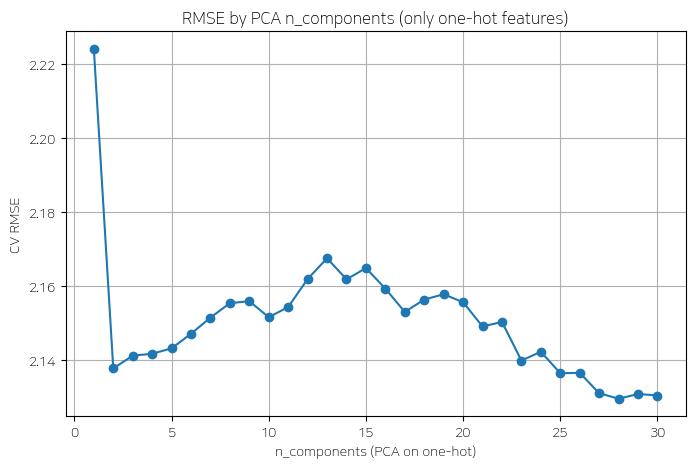

최적 n_components = 28, 최소 RMSE = 2.1295


In [ ]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


X = train.drop(columns=["box_off_num"])
y = train["box_off_num"]

onehot_cols = [col for col in X.columns if 'genre_' in col or 'screening_rat_' in col or 'year_' in col or 'month_' in col]
numeric_cols = [col for col in X.columns if col not in onehot_cols]

X_cat = X[onehot_cols].copy()
X_num = X[numeric_cols].copy()

# 4. 수치형 피처 스케일링
scaler = StandardScaler()
X_num_scaled = scaler.fit_transform(X_num)

# 5. n_components 반복 실험
rmse_list = []
component_range = range(1, min(len(onehot_cols), 31))  # 최대 30차원까지 (또는 원핫 수 미만)

for n in component_range:
    pca = PCA(n_components=n)
    X_cat_pca = pca.fit_transform(X_cat)

    # 합치기
    X_combined = np.concatenate([X_num_scaled, X_cat_pca], axis=1)

    # 모델 훈련 + 교차검증
    model = Ridge(alpha=1.0)
    scores = cross_val_score(model, X_combined, y, cv=5, scoring='neg_root_mean_squared_error')
    rmse = -scores.mean()
    rmse_list.append(rmse)

# 6. 결과 시각화
plt.figure(figsize=(8, 5))
plt.plot(component_range, rmse_list, marker='o')
plt.xlabel("n_components (PCA on one-hot)")
plt.ylabel("CV RMSE")
plt.title("RMSE by PCA n_components (only one-hot features)")
plt.grid(True)
plt.show()

# 7. 최적 차원 출력
best_n = component_range[np.argmin(rmse_list)]
print(f"최적 n_components = {best_n}, 최소 RMSE = {min(rmse_list):.4f}")

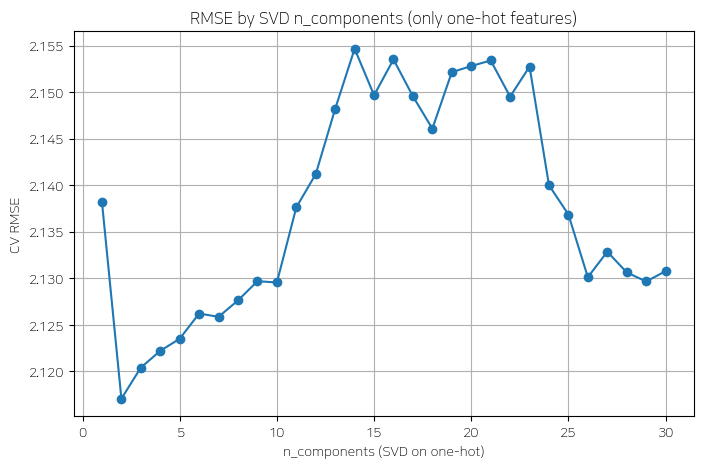

최적 n_components = 2, 최소 RMSE = 2.1171


In [ ]:
from sklearn.decomposition import TruncatedSVD

X = train.drop(columns=["box_off_num"])
y = train["box_off_num"]

onehot_cols = [col for col in X.columns if 'genre_' in col or 'screening_rat_' in col or 'year_' in col or 'month_' in col]
numeric_cols = [col for col in X.columns if col not in onehot_cols]

X_cat = X[onehot_cols].copy()
X_num = X[numeric_cols].copy()

# 4. 수치형 피처 스케일링
scaler = StandardScaler()
X_num_scaled = scaler.fit_transform(X_num)

# 5. n_components 반복 실험
rmse_list = []
component_range = range(1, min(len(onehot_cols), 31))  # 최대 30차원까지 (또는 원핫 수 미만)

for n in component_range:
    trunSVD = TruncatedSVD(n_components=n)
    X_cat_svd = trunSVD.fit_transform(X_cat)

    # 합치기
    X_combined = np.concatenate([X_num_scaled, X_cat_svd], axis=1)

    # 모델 훈련 + 교차검증
    model = Ridge(alpha=1.0)
    scores = cross_val_score(model, X_combined, y, cv=5, scoring='neg_root_mean_squared_error')
    rmse = -scores.mean()
    rmse_list.append(rmse)

# 6. 결과 시각화
plt.figure(figsize=(8, 5))
plt.plot(component_range, rmse_list, marker='o')
plt.xlabel("n_components (SVD on one-hot)")
plt.ylabel("CV RMSE")
plt.title("RMSE by SVD n_components (only one-hot features)")
plt.grid(True)
plt.show()

# 7. 최적 차원 출력
best_n = component_range[np.argmin(rmse_list)]
print(f"최적 n_components = {best_n}, 최소 RMSE = {min(rmse_list):.4f}")

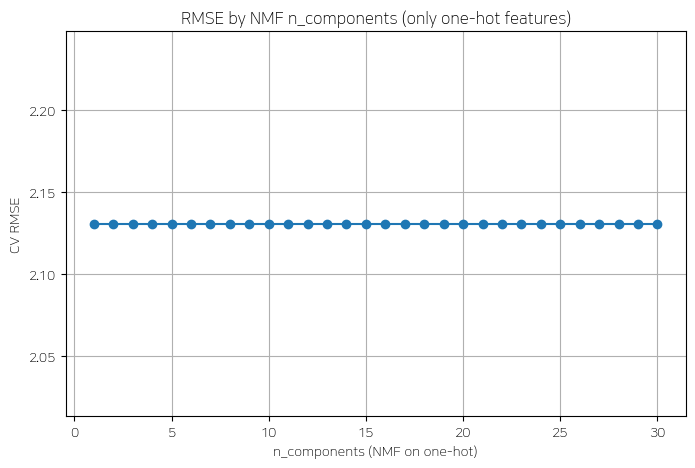

최적 n_components = 1, 최소 RMSE = 2.1308


In [ ]:
from sklearn.decomposition import NMF

X = train.drop(columns=["box_off_num"])
y = train["box_off_num"]

onehot_cols = [col for col in X.columns if 'genre_' in col or 'screening_rat_' in col or 'year_' in col or 'month_' in col]
numeric_cols = [col for col in X.columns if col not in onehot_cols]

X_cat = X[onehot_cols].copy()
X_num = X[numeric_cols].copy()

# 4. 수치형 피처 스케일링
scaler = StandardScaler()
X_num_scaled = scaler.fit_transform(X_num)

# 5. n_components 반복 실험
rmse_list = []
component_range = range(1, min(len(onehot_cols), 31))  # 최대 30차원까지 (또는 원핫 수 미만)

for n in component_range:
    nmf = NMF(n_components=n)
    X_cat_nmf = trunSVD.fit_transform(X_cat)

    # 합치기
    X_combined = np.concatenate([X_num_scaled, X_cat_nmf], axis=1)

    # 모델 훈련 + 교차검증
    model = Ridge(alpha=1.0)
    scores = cross_val_score(model, X_combined, y, cv=5, scoring='neg_root_mean_squared_error')
    rmse = -scores.mean()
    rmse_list.append(rmse)

# 6. 결과 시각화
plt.figure(figsize=(8, 5))
plt.plot(component_range, rmse_list, marker='o')
plt.xlabel("n_components (NMF on one-hot)")
plt.ylabel("CV RMSE")
plt.title("RMSE by NMF n_components (only one-hot features)")
plt.grid(True)
plt.show()

# 7. 최적 차원 출력
best_n = component_range[np.argmin(rmse_list)]
print(f"최적 n_components = {best_n}, 최소 RMSE = {min(rmse_list):.4f}")

##### PCA, SVD (n_components=2) + 라쏘, 릿지, 엘라스틱넷, 랜덤포레스트, XGB, LGBM

In [ ]:
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import numpy as np

# 타겟
y = train["box_off_num"]

# 입력 피처
X = train.drop(columns=["box_off_num"])

# 분리
onehot_cols = [col for col in X.columns if 'genre_' in col or 'screening_rat_' in col or 'year_' in col or 'month_' in col]
numeric_cols = [col for col in X.columns if col not in onehot_cols]

X_cat = X[onehot_cols]
X_num = X[numeric_cols]

# 수치형 스케일링
scaler = StandardScaler()
X_num_scaled = scaler.fit_transform(X_num)

# PCA 및 SVD (n_components=2)
pca = PCA(n_components=2)
X_cat_pca = pca.fit_transform(X_cat)

svd = TruncatedSVD(n_components=2)
X_cat_svd = svd.fit_transform(X_cat)

# 최종 입력
X_pca = np.concatenate([X_num_scaled, X_cat_pca], axis=1)
X_svd = np.concatenate([X_num_scaled, X_cat_svd], axis=1)

In [ ]:
from sklearn.model_selection import KFold

def evaluate_models(X_input, y):
    models = {
        "Ridge": Ridge(alpha=1.0),
        "Lasso": Lasso(alpha=0.1, max_iter=10000),
        "ElasticNet": ElasticNet(alpha=0.1, l1_ratio=0.5, max_iter=10000),
        "RandomForest": RandomForestRegressor(n_estimators=100, random_state=156),
        "XGBoost": XGBRegressor(n_estimators=100, random_state=156, verbosity=0),
        "LightGBM": LGBMRegressor(n_estimators=100, random_state=156,verbose=-1),
    }

    results = {}

    for name, model in models.items():
        scores = cross_val_score(model, X_input, y, cv=5, scoring="neg_root_mean_squared_error")
        rmse = -scores.mean()
        results[name] = rmse
        print(f"{name}: RMSE = {rmse:.4f}")

    return results

In [ ]:
print("\n Results on PCA(n=2):")
results_pca = evaluate_models(X_pca, y)


 Results on PCA(n=2):
Ridge: RMSE = 2.1377
Lasso: RMSE = 2.1666
ElasticNet: RMSE = 2.1545
RandomForest: RMSE = 1.9322
XGBoost: RMSE = 2.0412
LightGBM: RMSE = 1.9800


In [ ]:
print("\n Results on SVD(n=2):")
results_svd = evaluate_models(X_svd, y)


 Results on SVD(n=2):
Ridge: RMSE = 2.1171
Lasso: RMSE = 2.1707
ElasticNet: RMSE = 2.1664
RandomForest: RMSE = 1.8813
XGBoost: RMSE = 2.0005
LightGBM: RMSE = 1.9792


##### SVD + 모델 조합

1. 릿지 + 랜덤포레스트 + LGBM

In [ ]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import numpy as np

# 모델 정의
models = {
    "Ridge": Ridge(alpha=1.0),
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=156),
    "LightGBM": LGBMRegressor(n_estimators=100, random_state=156, verbose=-1),
}

# 입력 피처 (SVD 사용)
X_input = X_svd
kf = KFold(n_splits=5, shuffle=True, random_state=156)

# 각 fold마다 예측 저장
model_preds = {name: np.zeros(len(y)) for name in models}

for train_idx, val_idx in kf.split(X_input):
    X_tr, X_val = X_input[train_idx], X_input[val_idx]
    y_tr, y_val = y[train_idx], y[val_idx]

    for name, model in models.items():
        model.fit(X_tr, y_tr)
        preds = model.predict(X_val)
        model_preds[name][val_idx] = preds

# 단순 평균 앙상블
ensemble_pred_avg = np.mean([model_preds[name] for name in models], axis=0)
mse_avg = mean_squared_error(y, ensemble_pred_avg)
rmse_avg = np.sqrt(mse_avg)

print(f"🔹 단순 평균 앙상블 RMSE: {rmse_avg:.4f}")

🔹 단순 평균 앙상블 RMSE: 1.9036


In [ ]:
import numpy as np
import pandas as pd
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# 2. train 데이터에서 X, y 분리
X = train.drop(columns=['box_off_num'])
y = train['box_off_num'].values

# 3. train/validation 데이터 분리 (예: 8:2 비율)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=156
)

# 4. 원핫 인코딩된 컬럼명 리스트 지정 (필요에 따라 수정)
onehot_cols = [col for col in X.columns if
               col.startswith('genre_') or
               col.startswith('screening_rat_') or
               col.startswith('year_') or
               col.startswith('month_')]

# 5. 원핫 피처만 추출
X_train_onehot = X_train[onehot_cols]
X_val_onehot = X_val[onehot_cols]
X_test_onehot = test[onehot_cols]

# 6. SVD 적용 (n_components=2)
svd = TruncatedSVD(n_components=2, random_state=156)
svd.fit(X_train_onehot)

X_train_svd = svd.transform(X_train_onehot)
X_val_svd = svd.transform(X_val_onehot)
X_test_svd = svd.transform(X_test_onehot)

# 7. 수치형 피처 추출 (원핫 제외한 나머지 컬럼)
num_cols = [col for col in X.columns if col not in onehot_cols]

X_train_num = X_train[num_cols].values
X_val_num = X_val[num_cols].values
X_test_num = test[num_cols].values

# 8. 수치형 피처 + SVD 차원축소 결과 합치기
X_train_final = np.hstack([X_train_num, X_train_svd])
X_val_final = np.hstack([X_val_num, X_val_svd])
X_test_final = np.hstack([X_test_num, X_test_svd])

# 1. 모델 정의 (이전에 썼던 것과 동일)
models = {
    "Ridge": Ridge(alpha=1.0),
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=156),
    "LightGBM": LGBMRegressor(n_estimators=100, random_state=156, verbose=-1),
}

# 2. 전체 학습 데이터로 학습 & 테스트 예측
test_preds = []

for name, model in models.items():
    model.fit(X_train_final, y_train)  # 전체 데이터로 학습
    pred = model.predict(X_test_final)  # test 예측 (로그값 예측)
    test_preds.append(pred)

# 3. 단순 평균 앙상블
ensemble_pred_log = np.mean(test_preds, axis=0)

# 4. 로그 변환 복원
ensemble_pred = np.expm1(ensemble_pred_log)

# 5. 결과 출력
print("✅ 최종 앙상블 예측 결과 (일부):")
print(ensemble_pred[:10])

✅ 최종 앙상블 예측 결과 (일부):
[ 865562.98559505  334881.43609396  575222.42935775  851053.71166788
 1267307.43092104    5164.8250778     6422.37059436    1628.57521099
    5203.11465112  213643.21614351]


In [ ]:
submission['box_off_num'] = ensemble_pred
submission.to_csv('submission_ensemble.csv', index=False)

from google.colab import files
files.download('submission_ensemble.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

* 점수가 너무 높게 나옴

2. 랜덤포레스트 + xgb + lgbm

In [ ]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import numpy as np

# 모델 정의
models = {
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=156),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=156, verbosity=0),
    "LightGBM": LGBMRegressor(n_estimators=100, random_state=156, verbose=-1),
}

# 입력 피처 (SVD 사용)
X_input = X_svd
kf = KFold(n_splits=5, shuffle=True, random_state=156)

# 각 fold마다 예측 저장
model_preds = {name: np.zeros(len(y)) for name in models}

for train_idx, val_idx in kf.split(X_input):
    X_tr, X_val = X_input[train_idx], X_input[val_idx]
    y_tr, y_val = y[train_idx], y[val_idx]

    for name, model in models.items():
        model.fit(X_tr, y_tr)
        preds = model.predict(X_val)
        model_preds[name][val_idx] = preds

# 단순 평균 앙상블
ensemble_pred_avg = np.mean([model_preds[name] for name in models], axis=0)
mse_avg = mean_squared_error(y, ensemble_pred_avg)
rmse_avg = np.sqrt(mse_avg)

print(f"🔹 단순 평균 앙상블 RMSE: {rmse_avg:.4f}")

🔹 단순 평균 앙상블 RMSE: 1.9438


3. 랜덤포레스트 + lgbm

In [ ]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import numpy as np

# 모델 정의
models = {
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=156),
    "LightGBM": LGBMRegressor(n_estimators=100, random_state=156, verbose=-1),
}

# 입력 피처 (SVD 사용)
X_input = X_svd
kf = KFold(n_splits=5, shuffle=True, random_state=156)

# 각 fold마다 예측 저장
model_preds = {name: np.zeros(len(y)) for name in models}

for train_idx, val_idx in kf.split(X_input):
    X_tr, X_val = X_input[train_idx], X_input[val_idx]
    y_tr, y_val = y[train_idx], y[val_idx]

    for name, model in models.items():
        model.fit(X_tr, y_tr)
        preds = model.predict(X_val)
        model_preds[name][val_idx] = preds

# 단순 평균 앙상블
ensemble_pred_avg = np.mean([model_preds[name] for name in models], axis=0)
mse_avg = mean_squared_error(y, ensemble_pred_avg)
rmse_avg = np.sqrt(mse_avg)

print(f"🔹 단순 평균 앙상블 RMSE: {rmse_avg:.4f}")

🔹 단순 평균 앙상블 RMSE: 1.9423


In [ ]:
import numpy as np
import pandas as pd
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# 2. train 데이터에서 X, y 분리
X = train.drop(columns=['box_off_num'])
y = train['box_off_num'].values

# 3. train/validation 데이터 분리 (예: 8:2 비율)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=156
)

# 4. 원핫 인코딩된 컬럼명 리스트 지정 (필요에 따라 수정)
onehot_cols = [col for col in X.columns if
               col.startswith('genre_') or
               col.startswith('screening_rat_') or
               col.startswith('year_') or
               col.startswith('month_')]

# 5. 원핫 피처만 추출
X_train_onehot = X_train[onehot_cols]
X_val_onehot = X_val[onehot_cols]
X_test_onehot = test[onehot_cols]

# 6. SVD 적용 (n_components=2)
svd = TruncatedSVD(n_components=2, random_state=156)
svd.fit(X_train_onehot)

X_train_svd = svd.transform(X_train_onehot)
X_val_svd = svd.transform(X_val_onehot)
X_test_svd = svd.transform(X_test_onehot)

# 7. 수치형 피처 추출 (원핫 제외한 나머지 컬럼)
num_cols = [col for col in X.columns if col not in onehot_cols]

X_train_num = X_train[num_cols].values
X_val_num = X_val[num_cols].values
X_test_num = test[num_cols].values

# 8. 수치형 피처 + SVD 차원축소 결과 합치기
X_train_final = np.hstack([X_train_num, X_train_svd])
X_val_final = np.hstack([X_val_num, X_val_svd])
X_test_final = np.hstack([X_test_num, X_test_svd])

# 1. 모델 정의 (이전에 썼던 것과 동일)
models = {
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=156),
    "LightGBM": LGBMRegressor(n_estimators=100, random_state=156, verbose=-1),
}

# 2. 전체 학습 데이터로 학습 & 테스트 예측
test_preds = []

for name, model in models.items():
    model.fit(X_train_final, y_train)  # 전체 데이터로 학습
    pred = model.predict(X_test_final)  # test 예측 (로그값 예측)
    test_preds.append(pred)

# 3. 단순 평균 앙상블
ensemble_pred_log = np.mean(test_preds, axis=0)

# 4. 로그 변환 복원
ensemble_pred = np.expm1(ensemble_pred_log)

# 5. 결과 출력
print("✅ 최종 앙상블 예측 결과 (일부):")
print(ensemble_pred[:10])

✅ 최종 앙상블 예측 결과 (일부):
[1.40767003e+06 2.82551828e+05 6.59743936e+05 1.02473765e+06
 1.92341207e+06 4.47060517e+03 6.12525792e+03 1.02891779e+03
 3.67184084e+03 3.68436709e+05]


##### SVD -> 랜덤포레스트

In [ ]:
import numpy as np
import pandas as pd
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# 2. train 데이터에서 X, y 분리
X = train.drop(columns=['box_off_num'])
y = train['box_off_num'].values

# 3. train/validation 데이터 분리 (예: 8:2 비율)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=156
)

# 4. 원핫 인코딩된 컬럼명 리스트 지정 (필요에 따라 수정)
onehot_cols = [col for col in X.columns if
               col.startswith('genre_') or
               col.startswith('screening_rat_') or
               col.startswith('year_') or
               col.startswith('month_')]

# 5. 원핫 피처만 추출
X_train_onehot = X_train[onehot_cols]
X_val_onehot = X_val[onehot_cols]
X_test_onehot = test[onehot_cols]

# 6. SVD 적용 (n_components=2)
svd = TruncatedSVD(n_components=2, random_state=156)
svd.fit(X_train_onehot)

X_train_svd = svd.transform(X_train_onehot)
X_val_svd = svd.transform(X_val_onehot)
X_test_svd = svd.transform(X_test_onehot)

# 7. 수치형 피처 추출 (원핫 제외한 나머지 컬럼)
num_cols = [col for col in X.columns if col not in onehot_cols]

X_train_num = X_train[num_cols].values
X_val_num = X_val[num_cols].values
X_test_num = test[num_cols].values

# 8. 수치형 피처 + SVD 차원축소 결과 합치기
X_train_final = np.hstack([X_train_num, X_train_svd])
X_val_final = np.hstack([X_val_num, X_val_svd])
X_test_final = np.hstack([X_test_num, X_test_svd])

# 9. 랜덤포레스트 학습
rf = RandomForestRegressor(random_state=156)
rf.fit(X_train_final, y_train)

# 10. 검증 데이터 예측 및 RMSE 출력
val_pred = rf.predict(X_val_final)
val_mse = mean_squared_error(y_val, val_pred)
val_rmse = np.sqrt(val_mse)
print(f"Validation RMSE: {val_rmse:.4f}")

# 11. test 데이터 예측
test_pred_log = rf.predict(X_test_final)
# 원래 스케일로 복원 (로그 역변환)
svd_test_pred = np.expm1(test_pred_log)

print("Test 예측값 일부:")
print(svd_test_pred[:5])

Validation RMSE: 1.8552
Test 예측값 일부:
[1607975.05333245  389117.97555797  536760.91897036 1093571.39057799
 1107303.42499871]


In [ ]:
submission['box_off_num'] = svd_test_pred
submission.to_csv('submission_svd.csv', index=False)

from google.colab import files
files.download('submission_svd.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

* 점수: 1458378.26318

##### SVD -> LightGBM

In [ ]:
import numpy as np
import pandas as pd
from sklearn.decomposition import TruncatedSVD
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# 2. train 데이터에서 X, y 분리
X = train.drop(columns=['box_off_num'])
y = train['box_off_num'].values

# 3. train/validation 데이터 분리 (예: 8:2 비율)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=156
)

# 4. 원핫 인코딩된 컬럼명 리스트 지정 (필요에 따라 수정)
onehot_cols = [col for col in X.columns if
               col.startswith('genre_') or
               col.startswith('screening_rat_') or
               col.startswith('year_') or
               col.startswith('month_')]

# 5. 원핫 피처만 추출
X_train_onehot = X_train[onehot_cols]
X_val_onehot = X_val[onehot_cols]
X_test_onehot = test[onehot_cols]

# 6. SVD 적용 (n_components=2)
svd = TruncatedSVD(n_components=2, random_state=156)
svd.fit(X_train_onehot)

X_train_svd = svd.transform(X_train_onehot)
X_val_svd = svd.transform(X_val_onehot)
X_test_svd = svd.transform(X_test_onehot)

# 7. 수치형 피처 추출 (원핫 제외한 나머지 컬럼)
num_cols = [col for col in X.columns if col not in onehot_cols]

X_train_num = X_train[num_cols].values
X_val_num = X_val[num_cols].values
X_test_num = test[num_cols].values

# 8. 수치형 피처 + SVD 차원축소 결과 합치기
X_train_final = np.hstack([X_train_num, X_train_svd])
X_val_final = np.hstack([X_val_num, X_val_svd])
X_test_final = np.hstack([X_test_num, X_test_svd])

# 9. 랜덤포레스트 학습
lgbm = LGBMRegressor(random_state=156)
lgbm.fit(X_train_final, y_train)

# 10. 검증 데이터 예측 및 RMSE 출력
val_pred = lgbm.predict(X_val_final)
val_mse = mean_squared_error(y_val, val_pred)
val_rmse = np.sqrt(val_mse)
print(f"Validation RMSE: {val_rmse:.4f}")

# 11. test 데이터 예측
test_pred_log = lgbm.predict(X_test_final)
# 원래 스케일로 복원 (로그 역변환)
lgbm_test_pred = np.expm1(test_pred_log)

print("Test 예측값 일부:")
print(lgbm_test_pred[:5])

Validation RMSE: 1.9681
Test 예측값 일부:
[1232316.93766626  205170.43995852  810904.85199785  960236.5676757
 3341011.42500269]


In [ ]:
submission['box_off_num'] = lgbm_test_pred
submission.to_csv('submission_lgbm.csv', index=False)

from google.colab import files
files.download('submission_lgbm.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

* 점수: 1350596.1463791998

##### SVD -> XGBoost

In [ ]:
import numpy as np
import pandas as pd
from sklearn.decomposition import TruncatedSVD
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# 2. train 데이터에서 X, y 분리
X = train.drop(columns=['box_off_num'])
y = train['box_off_num'].values

# 3. train/validation 데이터 분리 (예: 8:2 비율)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=156
)

# 4. 원핫 인코딩된 컬럼명 리스트 지정 (필요에 따라 수정)
onehot_cols = [col for col in X.columns if
               col.startswith('genre_') or
               col.startswith('screening_rat_') or
               col.startswith('year_') or
               col.startswith('month_')]

# 5. 원핫 피처만 추출
X_train_onehot = X_train[onehot_cols]
X_val_onehot = X_val[onehot_cols]
X_test_onehot = test[onehot_cols]

# 6. SVD 적용 (n_components=2)
svd = TruncatedSVD(n_components=2, random_state=156)
svd.fit(X_train_onehot)

X_train_svd = svd.transform(X_train_onehot)
X_val_svd = svd.transform(X_val_onehot)
X_test_svd = svd.transform(X_test_onehot)

# 7. 수치형 피처 추출 (원핫 제외한 나머지 컬럼)
num_cols = [col for col in X.columns if col not in onehot_cols]

X_train_num = X_train[num_cols].values
X_val_num = X_val[num_cols].values
X_test_num = test[num_cols].values

# 8. 수치형 피처 + SVD 차원축소 결과 합치기
X_train_final = np.hstack([X_train_num, X_train_svd])
X_val_final = np.hstack([X_val_num, X_val_svd])
X_test_final = np.hstack([X_test_num, X_test_svd])

# 9. 랜덤포레스트 학습
xgb = XGBRegressor(random_state=156)
xgb.fit(X_train_final, y_train)

# 10. 검증 데이터 예측 및 RMSE 출력
val_pred = xgb.predict(X_val_final)
val_mse = mean_squared_error(y_val, val_pred)
val_rmse = np.sqrt(val_mse)
print(f"Validation RMSE: {val_rmse:.4f}")

# 11. test 데이터 예측
test_pred_log = xgb.predict(X_test_final)
# 원래 스케일로 복원 (로그 역변환)
xgb_test_pred = np.expm1(test_pred_log)

print("Test 예측값 일부:")
print(xgb_test_pred[:5])

Validation RMSE: 1.9484
Test 예측값 일부:
[ 502098.    577924.06  956292.94  741164.2  3715110.2 ]


In [ ]:
submission['box_off_num'] = xgb_test_pred
submission.to_csv('submission_xgb.csv', index=False)

from google.colab import files
files.download('submission_xgb.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

* 점수: 1567296.874522475

##### PCA -> LGBM

In [ ]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# 2. train 데이터에서 X, y 분리
X = train.drop(columns=['box_off_num'])
y = train['box_off_num'].values

# 3. train/validation 데이터 분리 (예: 8:2 비율)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=156
)

# 4. 원핫 인코딩된 컬럼명 리스트 지정 (필요에 따라 수정)
onehot_cols = [col for col in X.columns if
               col.startswith('genre_') or
               col.startswith('screening_rat_') or
               col.startswith('year_') or
               col.startswith('month_')]

# 5. 원핫 피처만 추출
X_train_onehot = X_train[onehot_cols]
X_val_onehot = X_val[onehot_cols]
X_test_onehot = test[onehot_cols]

# 6. SVD 적용 (n_components=2)
pca = PCA(n_components=2, random_state=156)
pca.fit(X_train_onehot)

X_train_pca = pca.transform(X_train_onehot)
X_val_pca = pca.transform(X_val_onehot)
X_test_pca = pca.transform(X_test_onehot)

# 7. 수치형 피처 추출 (원핫 제외한 나머지 컬럼)
num_cols = [col for col in X.columns if col not in onehot_cols]

X_train_num = X_train[num_cols].values
X_val_num = X_val[num_cols].values
X_test_num = test[num_cols].values

# 8. 수치형 피처 + SVD 차원축소 결과 합치기
X_train_final = np.hstack([X_train_num, X_train_pca])
X_val_final = np.hstack([X_val_num, X_val_pca])
X_test_final = np.hstack([X_test_num, X_test_pca])

# 9. 랜덤포레스트 학습
lgbm = LGBMRegressor(random_state=156)
lgbm.fit(X_train_final, y_train)

# 10. 검증 데이터 예측 및 RMSE 출력
val_pred = lgbm.predict(X_val_final)
val_mse = mean_squared_error(y_val, val_pred)
val_rmse = np.sqrt(val_mse)
print(f"Validation RMSE: {val_rmse:.4f}")

# 11. test 데이터 예측
test_pred_log = lgbm.predict(X_test_final)
# 원래 스케일로 복원 (로그 역변환)
lgbm_pca_test_pred = np.expm1(test_pred_log)

print("Test 예측값 일부:")
print(lgbm_pca_test_pred[:5])

Validation RMSE: 2.0546
Test 예측값 일부:
[ 807658.94021418  200014.4713613   842255.91201307  572796.70448175
 1565248.19657523]


In [ ]:
submission['box_off_num'] = lgbm_pca_test_pred
submission.to_csv('submission_lgbm_pca.csv', index=False)

from google.colab import files
files.download('submission_lgbm_pca.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

* 점수: 1503419

##### PCA -> RF

In [ ]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# 2. train 데이터에서 X, y 분리
X = train.drop(columns=['box_off_num'])
y = train['box_off_num'].values

# 3. train/validation 데이터 분리 (예: 8:2 비율)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=156
)

# 4. 원핫 인코딩된 컬럼명 리스트 지정 (필요에 따라 수정)
onehot_cols = [col for col in X.columns if
               col.startswith('genre_') or
               col.startswith('screening_rat_') or
               col.startswith('year_') or
               col.startswith('month_')]

# 5. 원핫 피처만 추출
X_train_onehot = X_train[onehot_cols]
X_val_onehot = X_val[onehot_cols]
X_test_onehot = test[onehot_cols]

# 6. SVD 적용 (n_components=2)
pca = PCA(n_components=2, random_state=156)
pca.fit(X_train_onehot)

X_train_pca = pca.transform(X_train_onehot)
X_val_pca = pca.transform(X_val_onehot)
X_test_pca = pca.transform(X_test_onehot)

# 7. 수치형 피처 추출 (원핫 제외한 나머지 컬럼)
num_cols = [col for col in X.columns if col not in onehot_cols]

X_train_num = X_train[num_cols].values
X_val_num = X_val[num_cols].values
X_test_num = test[num_cols].values

# 8. 수치형 피처 + SVD 차원축소 결과 합치기
X_train_final = np.hstack([X_train_num, X_train_pca])
X_val_final = np.hstack([X_val_num, X_val_pca])
X_test_final = np.hstack([X_test_num, X_test_pca])

# 9. 랜덤포레스트 학습
rf = RandomForestRegressor(random_state=156)
rf.fit(X_train_final, y_train)

# 10. 검증 데이터 예측 및 RMSE 출력
val_pred = rf.predict(X_val_final)
val_mse = mean_squared_error(y_val, val_pred)
val_rmse = np.sqrt(val_mse)
print(f"Validation RMSE: {val_rmse:.4f}")

# 11. test 데이터 예측
test_pred_log = rf.predict(X_test_final)
# 원래 스케일로 복원 (로그 역변환)
rf_pca_test_pred = np.expm1(test_pred_log)

print("Test 예측값 일부:")
print(rf_pca_test_pred[:5])

Validation RMSE: 1.8627
Test 예측값 일부:
[1285185.4035871   501218.82523609  233482.62764689  818397.02834914
 1259284.80192801]


In [ ]:
submission['box_off_num'] = rf_pca_test_pred
submission.to_csv('submission_rf_pca.csv', index=False)

from google.colab import files
files.download('submission_rf_pca.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

* 점수: 1444832.347176336

#### **최적 파라미터 탐색**



In [ ]:
pip install hyperopt

In [ ]:
import numpy as np
import pandas as pd
from sklearn.decomposition import TruncatedSVD
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# 2. train 데이터에서 X, y 분리
X = train.drop(columns=['box_off_num'])
y = train['box_off_num'].values

# 3. train/validation 데이터 분리 (예: 8:2 비율)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=156
)

# 4. 원핫 인코딩된 컬럼명 리스트 지정 (필요에 따라 수정)
onehot_cols = [col for col in X.columns if
               col.startswith('genre_') or
               col.startswith('screening_rat_') or
               col.startswith('year_') or
               col.startswith('month_')]

# 5. 원핫 피처만 추출
X_train_onehot = X_train[onehot_cols]
X_val_onehot = X_val[onehot_cols]
X_test_onehot = test[onehot_cols]

# 6. SVD 적용 (n_components=2)
svd = TruncatedSVD(n_components=2, random_state=156)
svd.fit(X_train_onehot)

X_train_svd = svd.transform(X_train_onehot)
X_val_svd = svd.transform(X_val_onehot)
X_test_svd = svd.transform(X_test_onehot)

# 7. 수치형 피처 추출 (원핫 제외한 나머지 컬럼)
num_cols = [col for col in X.columns if col not in onehot_cols]

X_train_num = X_train[num_cols].values
X_val_num = X_val[num_cols].values
X_test_num = test[num_cols].values

# 8. 수치형 피처 + SVD 차원축소 결과 합치기
X_train_final_svd = np.hstack([X_train_num, X_train_svd])
X_val_final_svd = np.hstack([X_val_num, X_val_svd])
X_test_final_svd = np.hstack([X_test_num, X_test_svd])

In [ ]:
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
from sklearn.model_selection import cross_val_score
from lightgbm import LGBMRegressor
import numpy as np

# 📌 하이퍼파라미터 탐색 공간 정의
param_space = {
    'num_leaves': hp.quniform('num_leaves', 20, 100, 1),
    'max_depth': hp.quniform('max_depth', 3, 15, 1),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
    'min_child_samples': hp.quniform('min_child_samples', 5, 100, 1),
    'subsample': hp.uniform('subsample', 0.6, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1.0),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
    'n_estimators': 100  # 고정 or 튜닝 대상에 추가 가능
}

# 📌 목적 함수 정의 (RMSE 기준)
def objective(params):
    # 정수형 파라미터 변환
    params['num_leaves'] = int(params['num_leaves'])
    params['max_depth'] = int(params['max_depth'])
    params['min_child_samples'] = int(params['min_child_samples'])

    model = LGBMRegressor(**params, random_state=156, verbose=-1)
    score = -cross_val_score(model, X_train_final_svd, y_train,
                             scoring="neg_root_mean_squared_error", cv=5).mean()

    return {'loss': score, 'status': STATUS_OK}

# 📌 탐색 수행
trials = Trials()
best = fmin(fn=objective,
            space=param_space,
            algo=tpe.suggest,  # Tree-structured Parzen Estimator
            max_evals=50,
            trials=trials,
            rstate=np.random.default_rng(42))

print("🎯 Best Hyperparameters:", best)

100%|██████████| 50/50 [00:10<00:00,  4.65trial/s, best loss: 1.9124589292324128]
🎯 Best Hyperparameters: {'colsample_bytree': np.float64(0.8104165716895848), 'learning_rate': np.float64(0.09014471888177232), 'max_depth': np.float64(12.0), 'min_child_samples': np.float64(46.0), 'num_leaves': np.float64(64.0), 'reg_alpha': np.float64(0.6741396008793589), 'reg_lambda': np.float64(0.6641624975844865), 'subsample': np.float64(0.6133265829153053)}


In [ ]:
from lightgbm import LGBMRegressor

# best는 hyperopt 결과 딕셔너리 (문자열 키에 값이 있음)
# 정수형으로 캐스팅이 필요한 값들 먼저 변환
best_lgbm_params = {
    'num_leaves': int(best['num_leaves']),
    'max_depth': int(best['max_depth']),
    'learning_rate': best['learning_rate'],
    'min_child_samples': int(best['min_child_samples']),
    'subsample': best['subsample'],
    'colsample_bytree': best['colsample_bytree'],
    'reg_alpha': best['reg_alpha'],
    'reg_lambda': best['reg_lambda'],
    'n_estimators': 100,  # 필요 시 변경 가능
    'random_state': 42
}

# 모델 생성 및 학습
lgbm_model = LGBMRegressor(**best_lgbm_params)
lgbm_model.fit(X_train_final_svd, y_train)

# 예측 수행
preds_log = lgbm_model.predict(X_test_final_svd)
svd_lgbm_test_pred = np.expm1(preds_log)

print("Test 예측값 일부:")
print(svd_lgbm_test_pred[:5])

Test 예측값 일부:
[1042608.00790997  227339.79934243 1009910.65310991 1220843.9408181
 2764542.76891257]


In [ ]:
submission['box_off_num'] = svd_lgbm_test_pred
submission.to_csv('submission_svd_lgbm.csv', index=False)

from google.colab import files
files.download('submission_svd_lgbm.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

* 점수: 1533122.6184283756

차원 축소를 진행한 모델링 최고 점수:

#### **최종 결론**

(1) PCA, SVD, NMF + 릿지로 수행 결과 SVD 가 n_components=2 에서 최소 RMSE 가 제일 작았음. => SVD 선택

(2) SVD 수행 후, 릿지, 라쏘, 엘라스틱넷, 랜덤포레스트, XGB, LGBM 돌려봄

(3) SVD 후에 다양한 모델들을 결합하여 예측했더니 오히려 성능 떨어짐.

(4) SVD 후 모델 1개로 최종 예측 실시 => LGBM 성능 제일 높았음.

(5) LGBM 파라미터 최적화 후 학습 실시해봄 => 하지만, 오히려 성능 떨어짐


**결론**

**TruncatdSVD (n_components) 차원 축소 후, LightGBM 수행의 경우 성능이 제일 좋았음. (1350596.15)**

## **결론**

- Stacking 최고 점수: 1551493.0510696012
- Blending 최고 점수: 1410308.82
- 차원 축소 최고 점수: 1350596.1463791998

따라서 TruncatedSVD를 적용하여 차원 축소 후, Light GBM을 적용한 모델의 성능이 가장 높은 것을 확인할 수 있었다.